In [893]:
import requests, os, re, time, random
import json
from tqdm import tqdm
import numpy as np, pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns
import folium
from folium.plugins import MarkerCluster
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException, WebDriverException
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import shutil

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings(action= 'ignore')

# Scraping Bina.az - Absheron Distinct

In [ ]:
url = 'https://bina.az/baki/alqi-satqi/menziller/yeni-tikili?location_ids%5B%5D=&location_ids%5B%5D=316&location_ids%5B%5D=362&location_ids%5B%5D=258&location_ids%5B%5D=65&location_ids%5B%5D=263&location_ids%5B%5D=116&location_ids%5B%5D=194&location_ids%5B%5D=365&location_ids%5B%5D=50&location_ids%5B%5D=115&location_ids%5B%5D=261&location_ids%5B%5D=198&location_ids%5B%5D=112&location_ids%5B%5D=265&location_ids%5B%5D=113&location_ids%5B%5D=241&location_ids%5B%5D=111&location_ids%5B%5D=114&location_ids%5B%5D=106&location_ids%5B%5D=197'
driver_path = r"C:\Users\TEXNO\Downloads\chromedriver-win64\chromedriver-win64\chromedriver.exe"

service = Service(driver_path)
driver = webdriver.Chrome(service=service)
driver.get(url)

In [ ]:
elan_sayi_text = bs.find('span', class_="sc-500242ec-0 lcYHId sc-85d10951-2 fzgacQ").text.strip()
elan_sayi = int(elan_sayi_text.replace("(", "").replace(")", "")) 
count = 0
nonsense = True

while nonsense:
    last_height = driver.execute_script("return document.body.scrollHeight")
    driver.execute_script(f"window.scrollTo(0, {last_height});")
    bs = BeautifulSoup(driver.page_source, 'html.parser')
    number_of_items = len(bs.find_all('a' , {'data-cy': 'item-card-link'}))
    if number_of_items < elan_sayi:
        if count > 30:
            print(f'Number of Scrolls: {count} Number of Houses: {elan_sayi}. Number of Extracted Houses: {number_of_items}')
    else:
        nonsense = False
    count+=1

urls_for_absheron = bs.find_all('a' , {'data-cy': 'item-card-link'})

In [ ]:
urls_for_absheron = ['https://bina.az' + i['href'] for i in urls_for_absheron]

In [ ]:
absheron_urls_df = pd.DataFrame({
    'Region': 'Absheron',
    'URL': urls_for_absheron
})

absheron_urls_df.to_csv('absheron_urls.csv', index=False)

In [ ]:
titles = []
info_tags = []
additional_tags = []
mortgage = []
seller_type = []
latitude = []
longitude = []
images = []
prices = []

for url in tqdm(urls_for_absheron):
    headers = {'User-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36'}
    request = requests.get(url, headers=headers)

    nonsense = True
    count = 0
    while nonsense:
        if request.status_code != 200:
            time.sleep(2)
            request = requests.get(url, headers = headers)
            count += 1
            if count == 5:
                print(f'Request for {url} has been unsuccessful. The error code is {request.status_code}') 
                nonsense = False
        else:
            nonsense = False
    
    html_code = request.content
    soup = BeautifulSoup(html_code, 'html.parser')

    try:
        title = soup.find('h1', {'class':'product-title'}).get_text(strip=True).replace('\xa0', ' ')
        titles.append(title)
    except:
        titles.append(None)
        
    try:
        properties = soup.find_all("div", class_="product-properties__i")
    
        data = {}
        for i in properties:
            key = i.find("label", class_="product-properties__i-name").get_text(strip=True)
            value = i.find("span", class_="product-properties__i-value").get_text(strip=True)
            data[key] = value
    
        info_tags.append(data)
    except:
        info_tags.append(None)
        
    try:
        additional_tag = [i.get_text(strip=True) for i in soup.find_all("div", class_="product-labels__i")]
        additional_tags.append(additional_tag)
    except:
        additional_tags.append(None)
        
    try:
        mortgage_info = soup.find('div', {'data-stat':'product-kapitalbank-btn'}).get_text(strip=True)
        mortgage.append(mortgage_info)
    except:
        mortgage.append(None)

    try:
        seller_type_info = soup.find('div', {'class':'product-owner__info-region'}).get_text(strip=True)
        seller_type.append(seller_type_info)
    except:
        seller_type.append(None)
        
    try:
        location = soup.find('div', attrs={'id': 'item_map'})
        latitude_info = location.get('data-lat')
        longitude_info = location.get('data-lng')
        latitude.append(latitude_info)
        longitude.append(longitude_info)
    except:
        latitude.append(None)
        longitude.append(None)
        
    try:
        image = soup.find('img')['src']
        images.append(image)
    except:
        images.append(None)

    try:
        price = soup.find('span', class_='price-val').get_text(strip=True).replace(' ', '')
        prices.append(price)
    except:
        prices.append(None)  

In [ ]:
absheron_df = pd.DataFrame(zip(urls_for_absheron, titles, info_tags, additional_tags, mortgage, seller_type, latitude, longitude, images, prices) ,
            columns= ['url', 'title', 'info_tags', 'additional_tags', 'mortgage', 'seller_type', 'latitude', 'longitude', 'images', 'prices'])

In [ ]:
absheron_df.to_csv('absheron_df.csv', index=False)

# Data Cleaning on Absheron Dataset

In [649]:
absheron_df = pd.read_csv(r'C:\Users\TEXNO\Desktop\Jupiter\Bina_az_datasets\absheron_df.csv')

In [651]:
absheron_df.duplicated().sum()

3

In [653]:
absheron_df = absheron_df.drop_duplicates()

In [655]:
absheron_df.isnull().sum()

url                 0
title               1
info_tags           0
additional_tags     0
mortgage           47
seller_type        53
latitude            1
longitude           1
images              0
prices              1
dtype: int64

In [657]:
absheron_df.drop(['mortgage'], axis=1, inplace=True)

In [659]:
absheron_df.dropna(subset=['title'], inplace=True)

In [661]:
absheron_df['area_sqm'] = [eval(i).get('Sahə') for i in absheron_df['info_tags']]

In [662]:
absheron_df['floor'] = [eval(i).get('Mərtəbə') for i in absheron_df['info_tags']]

In [663]:
absheron_df['room_count'] = [int(eval(i).get('Otaq sayı')) for i in absheron_df['info_tags']]

In [665]:
absheron_df['title_deed'] = [eval(i).get('Çıxarış') for i in absheron_df['info_tags']]

In [667]:
absheron_df['renovation_status'] = [eval(i).get('Təmir') for i in absheron_df['info_tags']]

In [668]:
absheron_df['mortgage_availability'] = [eval(i).get('İpoteka') for i in absheron_df['info_tags']]

In [670]:
absheron_df.drop(['info_tags'], axis=1, inplace=True)

In [671]:
absheron_df['Tag_Çıxarış'] = absheron_df['additional_tags'].apply(lambda x: 1 if 'Çıxarış var' in x else 0)
absheron_df['Tag_Təmirli'] = absheron_df['additional_tags'].apply(lambda x: 1 if 'Təmirli' in x else 0)
absheron_df['Tag_İpoteka'] = absheron_df['additional_tags'].apply(lambda x: 1 if 'İpoteka var' in x else 0)

In [673]:
absheron_df.drop(['additional_tags'], axis=1, inplace=True)

In [674]:
absheron_df['location'] = [i.split(', ')[1] for i in absheron_df['title']]

In [675]:
absheron_df.drop(['title'], axis=1, inplace=True)

In [677]:
len(absheron_df[absheron_df['Tag_İpoteka'] == 0])

1151

In [678]:
len(absheron_df[absheron_df['mortgage_availability'].isnull()])

1151

In [680]:
absheron_df[(absheron_df['Tag_İpoteka'] == 0) & (absheron_df['mortgage_availability'].notna())]

,url,seller_type,latitude,longitude,images,prices,area_sqm,floor,room_count,title_deed,renovation_status,mortgage_availability,Tag_Çıxarış,Tag_Təmirli,Tag_İpoteka,location


In [686]:
absheron_df['mortgage_availability'].fillna(0, inplace=True)

In [690]:
absheron_df.loc[absheron_df['mortgage_availability'] == 'var', 'mortgage_availability'] = 1

In [691]:
absheron_df['mortgage_availability'] = absheron_df['mortgage_availability'].astype('int64')

In [693]:
absheron_df.drop(['Tag_İpoteka'], axis=1, inplace=True)

In [696]:
absheron_df[(absheron_df['Tag_Çıxarış'] == 0) & (absheron_df['title_deed'] == 'var')]

,url,seller_type,latitude,longitude,images,prices,area_sqm,floor,room_count,title_deed,renovation_status,mortgage_availability,Tag_Çıxarış,Tag_Təmirli,location


In [699]:
absheron_df['title_deed'] = (absheron_df['title_deed'] == 'var').astype('int64')

In [701]:
absheron_df.drop(['Tag_Çıxarış'], axis=1, inplace=True)

In [703]:
absheron_df[(absheron_df['Tag_Təmirli'] == 0) & (absheron_df['renovation_status'] == 'var')]

,url,seller_type,latitude,longitude,images,prices,area_sqm,floor,room_count,title_deed,renovation_status,mortgage_availability,Tag_Təmirli,location


In [705]:
absheron_df['renovation_status'] = (absheron_df['renovation_status'] == 'var').astype('int64')

In [707]:
absheron_df.drop(['Tag_Təmirli'], axis=1, inplace=True)

In [709]:
len(absheron_df.loc[absheron_df['seller_type'].isnull()])

52

In [711]:
absheron_df.dropna(subset=['seller_type'], inplace=True)

In [713]:
absheron_df['seller_type'].value_counts()

seller_type
vasitəçi (agent)    1112
mülkiyyətçi          221
Name: count, dtype: int64

In [715]:
absheron_df.loc[absheron_df['seller_type'] == 'vasitəçi (agent)', 'seller_type'] = 0

In [717]:
absheron_df.loc[absheron_df['seller_type'] == 'mülkiyyətçi', 'seller_type'] = 1

In [718]:
absheron_df['seller_type'] = absheron_df['seller_type'].astype('int64')

In [719]:
absheron_df['area_sqm'] = absheron_df['area_sqm'].str.replace(' m²', '').astype('float64')

In [720]:
absheron_df['floor_number'] = absheron_df['floor'].str.split(' / ').str[0].astype('int64')

In [721]:
absheron_df['total_floor'] = absheron_df['floor'].str.split(' / ').str[1].astype('int64')

In [722]:
absheron_df['floor_ratio'] = absheron_df['floor_number'] / absheron_df['total_floor']

In [729]:
absheron_df['is_highest_floor'] = (absheron_df['floor_ratio'] == 1).astype('int64')

In [731]:
absheron_df.drop(['floor'], axis=1, inplace=True)

In [733]:
absheron_df['prices'] = absheron_df['prices'].astype('int64')

In [735]:
absheron_df['location'].value_counts()

location
Masazır q.              1160
Məmmədli q.               69
Saray q.                  52
Mehdiabad q.              19
Abşeron r.                13
Ceyranbatan q.            10
Aşağı Güzdək q.            4
Novxanı q.                 2
Xırdalan                   1
Görədil q.                 1
Azadlıq Prospekti m.       1
Kürdəxanı q.               1
Name: count, dtype: int64

In [737]:
absheron_df['room_size'] = absheron_df['area_sqm'] / absheron_df['room_count']

In [739]:
absheron_df.columns

Index(['url', 'seller_type', 'latitude', 'longitude', 'images', 'prices',
       'area_sqm', 'room_count', 'title_deed', 'renovation_status',
       'mortgage_availability', 'location', 'floor_number', 'total_floor',
       'floor_ratio', 'is_highest_floor', 'room_size'],
      dtype='object')

In [741]:
absheron_df = absheron_df[['url', 'room_count', 'area_sqm', 'room_size', 'floor_number', 'total_floor', 'floor_ratio', 
                           'latitude', 'longitude', 'title_deed', 'renovation_status',
                           'mortgage_availability', 'location', 'seller_type', 'images', 'prices']]

## Exploratory Data Analysis for Absheron Region

In [744]:
absheron_df.shape

(1333, 16)

In [746]:
absheron_df.isnull().sum()

url                      0
room_count               0
area_sqm                 0
room_size                0
floor_number             0
total_floor              0
floor_ratio              0
latitude                 0
longitude                0
title_deed               0
renovation_status        0
mortgage_availability    0
location                 0
seller_type              0
images                   0
prices                   0
dtype: int64

In [748]:
absheron_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1333 entries, 1 to 1386
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   url                    1333 non-null   object 
 1   room_count             1333 non-null   int64  
 2   area_sqm               1333 non-null   float64
 3   room_size              1333 non-null   float64
 4   floor_number           1333 non-null   int64  
 5   total_floor            1333 non-null   int64  
 6   floor_ratio            1333 non-null   float64
 7   latitude               1333 non-null   float64
 8   longitude              1333 non-null   float64
 9   title_deed             1333 non-null   int64  
 10  renovation_status      1333 non-null   int64  
 11  mortgage_availability  1333 non-null   int64  
 12  location               1333 non-null   object 
 13  seller_type            1333 non-null   int64  
 14  images                 1333 non-null   object 
 15  prices   

In [750]:
median = absheron_df['prices'].median()
q1 = absheron_df['prices'].quantile(0.25)
q3 = absheron_df['prices'].quantile(0.75)
iqr = q3 - q1

lower_whisker = max(absheron_df['prices'].min(), q1 - 1.5 * iqr)
upper_whisker = min(absheron_df['prices'].max(), q3 + 1.5 * iqr)

print(f'Median: {median}\nQ1: {q1}\nQ3: {q3}\nIQR: {iqr}\nLower Whisker: {lower_whisker}\nUpper Whisker: {upper_whisker}')

Median: 79000.0
Q1: 65000.0
Q3: 100000.0
IQR: 35000.0
Lower Whisker: 31300
Upper Whisker: 152500.0


In [752]:
absheron_df = absheron_df[absheron_df['prices'] <= upper_whisker * 1.5]

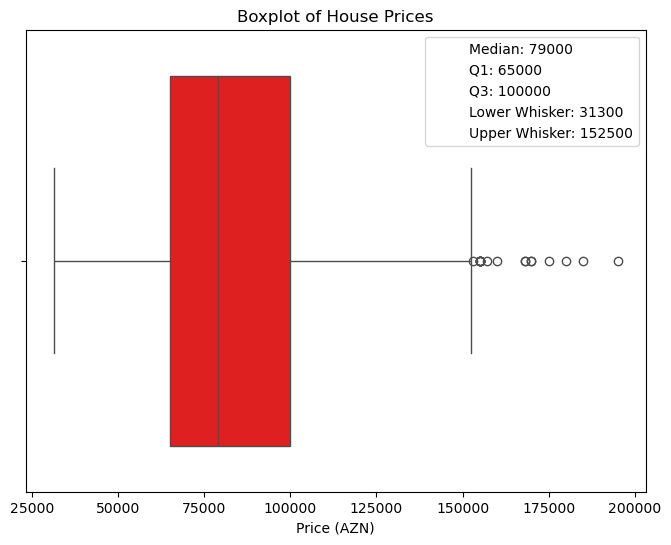

In [754]:
plt.figure(figsize=(8, 6))

sns.boxplot(x=absheron_df['prices'], color='red', whis=1.5)

median = absheron_df['prices'].median()
q1 = absheron_df['prices'].quantile(0.25)
q3 = absheron_df['prices'].quantile(0.75)
iqr = q3 - q1

lower_whisker = max(absheron_df['prices'].min(), q1 - 1.5 * iqr)
upper_whisker = min(absheron_df['prices'].max(), q3 + 1.5 * iqr)

legend_handles = [
    mpatches.Patch(color='none', label=f"Median: {median:.0f}"),
    mpatches.Patch(color='none', label=f"Q1: {q1:.0f}"),
    mpatches.Patch(color='none', label=f"Q3: {q3:.0f}"),
    mpatches.Patch(color='none', label=f"Lower Whisker: {lower_whisker:.0f}"),
    mpatches.Patch(color='none', label=f"Upper Whisker: {upper_whisker:.0f}")
]

plt.legend(handles=legend_handles, loc="upper right", frameon=True)
plt.title('Boxplot of House Prices')
plt.xlabel('Price (AZN)')
plt.show()

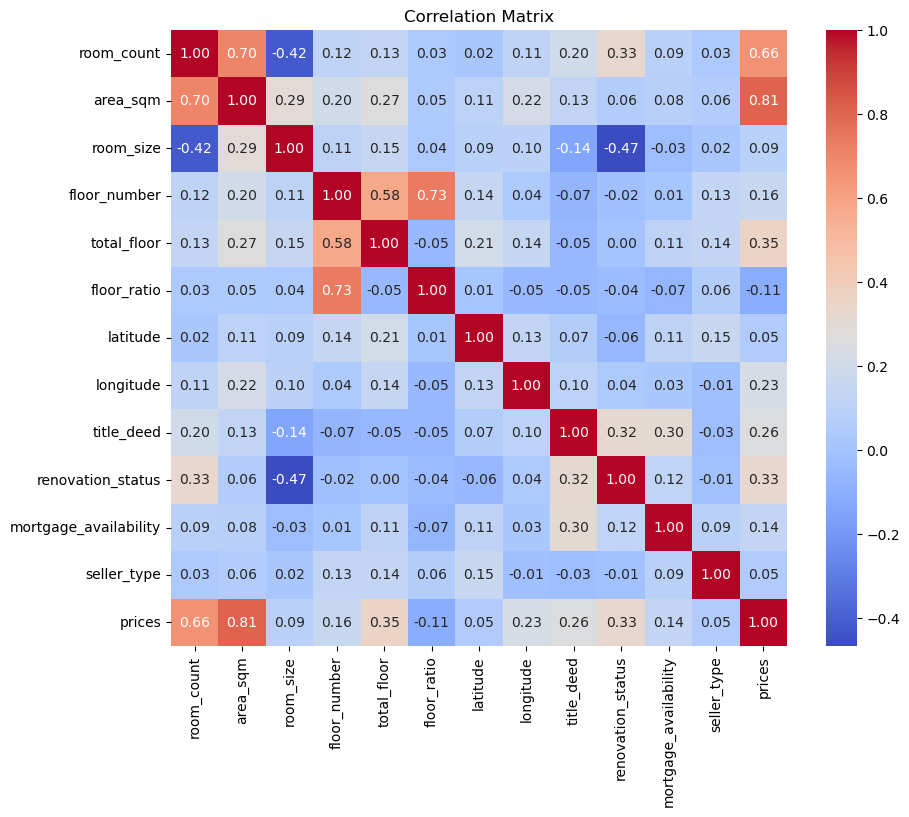

In [756]:
corr_matrix = absheron_df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

# Modelling 

## Linear Regression

In [827]:
X = absheron_df.drop(['prices', 'url', 'images', 'location'], axis=1)
y = np.log1p(absheron_df['prices'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

standard_scl = StandardScaler()
X_train = standard_scl.fit_transform(X_train)
X_test = standard_scl.transform(X_test)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [829]:
linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train)

LinearRegression()

In [831]:
y_pred_log = linear_model.predict(X_test_poly)
train_pred_log = linear_model.predict(X_train_poly)

y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)
train_pred_real = np.expm1(train_pred_log)
y_train_real = np.expm1(y_train)

In [833]:
r2_test_log = round(r2_score(y_test, y_pred_log), 3)
mae = round(mean_absolute_error(y_test_real, y_pred_real))
rmse = round(np.sqrt(mean_squared_error(y_test_real, y_pred_real)))

y_test_real = np.expm1(y_test)
y_pred_log = linear_model.predict(X_test_poly)
y_pred = np.exp(y_pred_log)
y_diff = np.abs(y_test_real - y_pred)

print(f"Test R²: {r2_test_log}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

Test R²: 0.868
MAE: 7506
RMSE: 10972


In [835]:
pd.DataFrame(zip(y_pred, y_test, y_diff), columns=['predictions', 'real_price', 'difference'])

,predictions,real_price,difference
0,146694.949285,11.813037,11694.949285
1,104940.583460,11.429555,12940.583460
2,128372.013503,11.790565,3627.986497
3,59764.153232,10.868587,7264.153232
4,73690.853955,11.156265,3690.853955
...,...,...,...
262,86919.186037,11.502885,12080.813963
263,44794.078700,10.878066,8205.921300
264,127861.783000,11.790565,4138.217000
265,68219.486899,11.205054,5280.513101


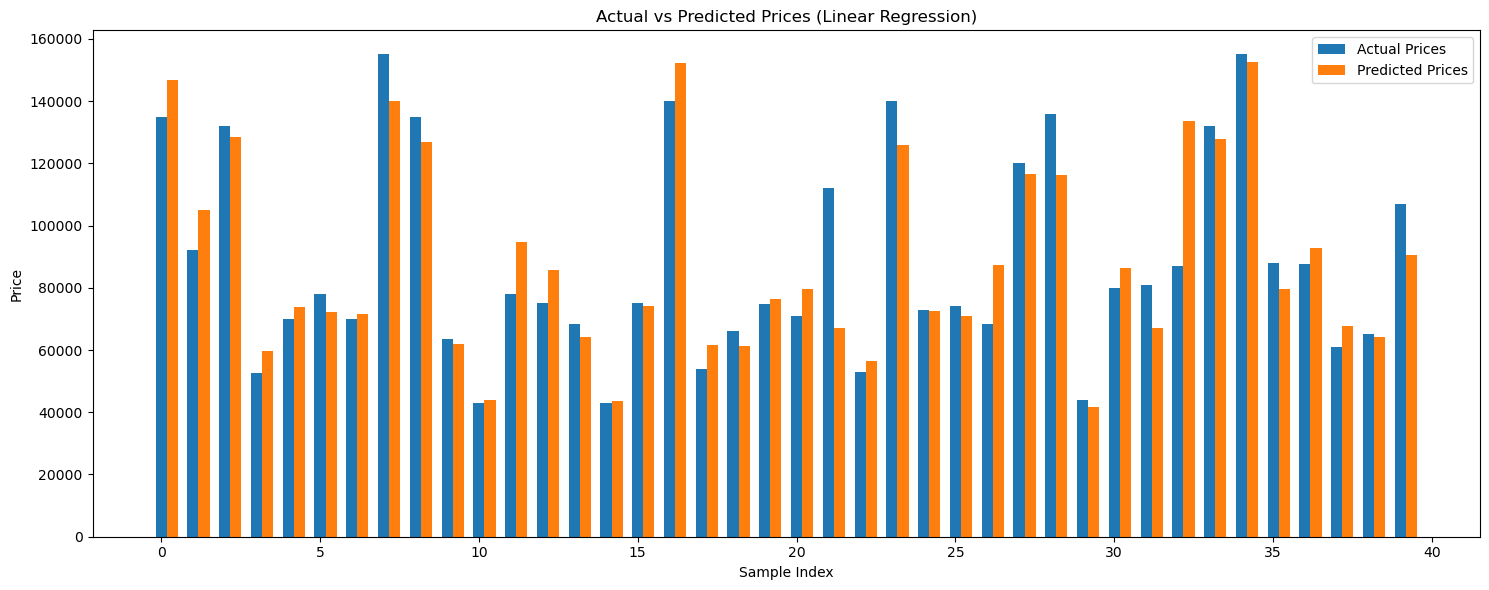

In [837]:
n = 40
indices = np.arange(n)
plt.figure(figsize=(15,6))
bar_width = 0.35
plt.bar(indices, y_test_real[:n], width=bar_width, label="Actual Prices")
plt.bar(indices + bar_width, y_pred_real[:n], width=bar_width, label="Predicted Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices (Linear Regression)")
plt.legend()
plt.tight_layout()
plt.show()

## Random Forest

In [839]:
X = absheron_df.drop(['prices', 'url', 'images', 'location'], axis=1)
y = absheron_df['prices']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [843]:
random_forest_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,      
    min_samples_leaf=3,
    min_samples_split=5,
    max_features=0.6,  
    random_state=42
)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, max_features=0.6, min_samples_leaf=3,
                      min_samples_split=5, n_estimators=200, random_state=42)

In [845]:
y_pred = random_forest_model.predict(X_test)
y_diff = np.abs(y_test - y_pred)

print(f"R²: {round(r2_score(y_test, y_pred), 3)}")
print(f"MAE: {round(mean_absolute_error(y_test, y_pred), 3)}")
print(f"RMSE: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)}")

R²: 0.884
MAE: 6427.477
RMSE: 9401.615


In [847]:
pd.DataFrame(zip(y_pred, y_test, y_diff), columns=['predictions', 'real_price', 'difference'])

,predictions,real_price,difference
0,137391.592713,135000,2391.592713
1,84956.577033,92000,7043.422967
2,129809.093987,132000,2190.906013
3,64336.723434,52500,11836.723434
4,75672.096393,70000,5672.096393
...,...,...,...
262,81964.100713,99000,17035.899287
263,50347.016848,53000,2652.983152
264,130785.340946,132000,1214.659054
265,73237.747170,73500,262.252830


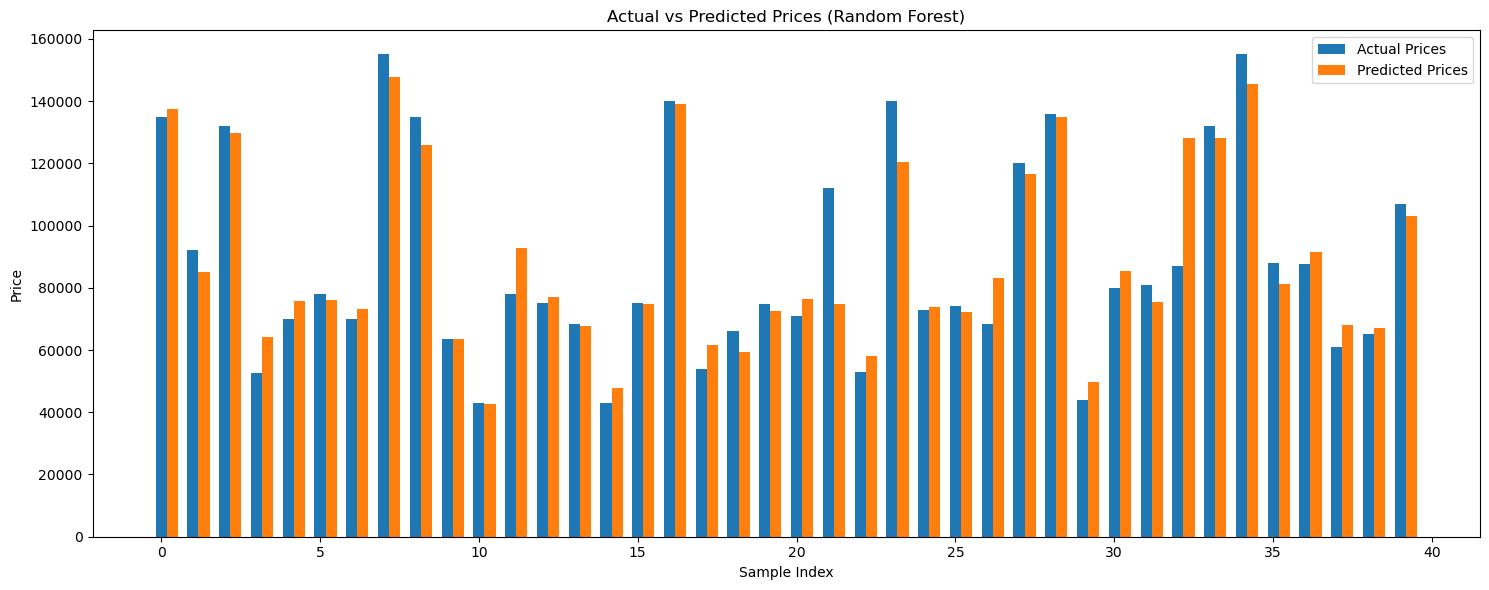

In [849]:
n = 40
indices = np.arange(n)
plt.figure(figsize=(15,6))
bar_width = 0.35
plt.bar(indices, y_test[:n], width=bar_width, label="Actual Prices")
plt.bar(indices + bar_width, y_pred[:n], width=bar_width, label="Predicted Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices (Random Forest)")
plt.legend()
plt.tight_layout()
plt.show()

## XGBoost

In [869]:
X = absheron_df.drop(['prices', 'url', 'images', 'location'], axis=1)
y = absheron_df['prices']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [871]:
xgb_model = XGBRegressor(n_estimators=1000,
                             learning_rate=0.05,
                             max_depth=6,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             random_state=42,
                             n_jobs=-1
                            )
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [872]:
y_pred = xgb_model.predict(X_test)
y_diff = np.abs(y_test - y_pred)

r2 = round(r2_score(y_test, y_pred), 3)
mae = round(mean_absolute_error(y_test, y_pred), 3)
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 3) 

print(f"XGBoost - Test R²: {r2}")
print(f"XGBoost - MAE: {mae}")
print(f"XGBoost - RMSE: {rmse}")

XGBoost - Test R²: 0.895
XGBoost - MAE: 6099.817
XGBoost - RMSE: 8947.869


In [873]:
pd.DataFrame(zip(y_pred, y_test, y_diff), columns=['predictions', 'real_price', 'difference'])

,predictions,real_price,difference
0,135802.343750,135000,802.343750
1,86085.375000,92000,5914.625000
2,133714.234375,132000,1714.234375
3,61637.949219,52500,9137.949219
4,75826.328125,70000,5826.328125
...,...,...,...
262,82797.656250,99000,16202.343750
263,49084.492188,53000,3915.507812
264,128229.492188,132000,3770.507812
265,75731.781250,73500,2231.781250


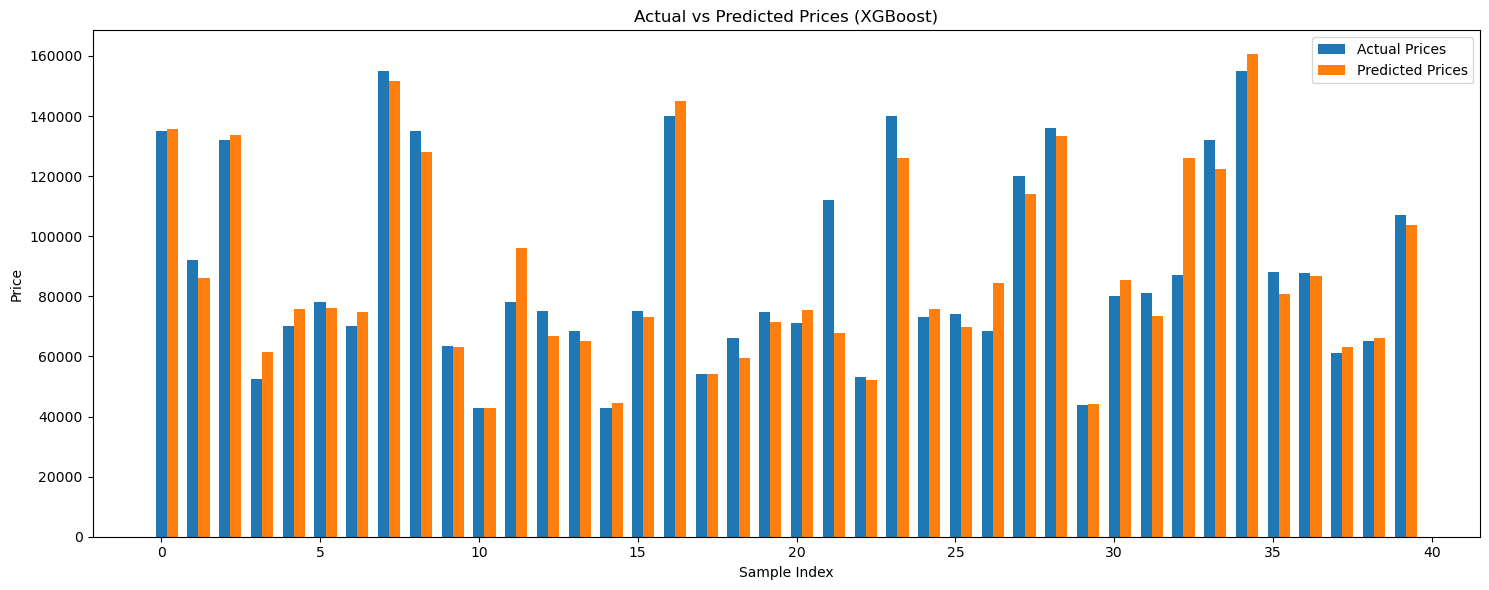

In [874]:
n = 40
indices = np.arange(n)
plt.figure(figsize=(15,6))
bar_width = 0.35
plt.bar(indices, y_test[:n], width=bar_width, label="Actual Prices")
plt.bar(indices + bar_width, y_pred[:n], width=bar_width, label="Predicted Prices")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.title("Actual vs Predicted Prices (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()

# Scraping Bina.az For All Other Distincts

## Binagadi Distinct

In [ ]:
url = 'https://bina.az/baki/alqi-satqi/menziller/yeni-tikili'
driver_path = r"C:\Users\TEXNO\Downloads\chromedriver-win64\chromedriver-win64\chromedriver.exe"

service = Service(driver_path)
driver = webdriver.Chrome(service=service)
driver.get(url)

In [ ]:
elan_sayi_text = bs.find('span', class_="sc-500242ec-0 lcYHId sc-85d10951-2 fzgacQ").text.strip()
elan_sayi = int(elan_sayi_text.replace("(", "").replace(")", "")) 
count = 0
nonsense = True

while nonsense:
    last_height = driver.execute_script("return document.body.scrollHeight")
    driver.execute_script(f"window.scrollTo(0, {last_height});")
    bs = BeautifulSoup(driver.page_source, 'html.parser')
    number_of_items = len(bs.find_all('a' , {'data-cy': 'item-card-link'}))
    if number_of_items < elan_sayi:
        if count > 30:
            print(f'Number of Scrolls: {count} Number of Houses: {elan_sayi}. Number of Extracted Houses: {number_of_items}')
    else:
        nonsense = False
    count+=1

urls_for_binagadi = bs.find_all('a' , {'data-cy': 'item-card-link'})

In [ ]:
urls_for_binagadi = ['https://bina.az' + i['href'] for i in urls_for_binagadi]

In [ ]:
binagadi_urls_df = pd.DataFrame({
    'Region': 'Binagadi',
    'URL': urls_for_binagadi
})

binagadi_urls_df.to_csv('binagadi_urls.csv', index=False)

In [ ]:
titles = []
info_tags = []
additional_tags = []
mortgage = []
seller_type = []
latitude = []
longitude = []
images = []
prices = []

for url in tqdm(urls_for_binagadi):
    headers = {'User-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36'}
    request = requests.get(url, headers=headers)

    nonsense = True
    count = 0
    while nonsense:
        if request.status_code != 200:
            time.sleep(2)
            request = requests.get(url, headers = headers)
            count += 1
            if count == 5:
                print(f'Request for {url} has been unsuccessful. The error code is {request.status_code}') 
                nonsense = False
        else:
            nonsense = False
    
    html_code = request.content
    soup = BeautifulSoup(html_code, 'html.parser')

    try:
        title = soup.find('h1', {'class':'product-title'}).get_text(strip=True).replace('\xa0', ' ')
        titles.append(title)
    except:
        titles.append(None)
        
    try:
        properties = soup.find_all("div", class_="product-properties__i")
    
        data = {}
        for i in properties:
            key = i.find("label", class_="product-properties__i-name").get_text(strip=True)
            value = i.find("span", class_="product-properties__i-value").get_text(strip=True)
            data[key] = value
    
        info_tags.append(data)
    except:
        info_tags.append(None)
        
    try:
        additional_tag = [i.get_text(strip=True) for i in soup.find_all("div", class_="product-labels__i")]
        additional_tags.append(additional_tag)
    except:
        additional_tags.append(None)
        
    try:
        mortgage_info = soup.find('div', {'data-stat':'product-kapitalbank-btn'}).get_text(strip=True)
        mortgage.append(mortgage_info)
    except:
        mortgage.append(None)

    try:
        seller_type_info = soup.find('div', {'class':'product-owner__info-region'}).get_text(strip=True)
        seller_type.append(seller_type_info)
    except:
        seller_type.append(None)
        
    try:
        location = soup.find('div', attrs={'id': 'item_map'})
        latitude_info = location.get('data-lat')
        longitude_info = location.get('data-lng')
        latitude.append(latitude_info)
        longitude.append(longitude_info)
    except:
        latitude.append(None)
        longitude.append(None)
        
    try:
        image = soup.find('img')['src']
        images.append(image)
    except:
        images.append(None)

    try:
        price = soup.find('span', class_='price-val').get_text(strip=True).replace(' ', '')
        prices.append(price)
    except:
        prices.append(None)  

In [ ]:
binagadi_df = pd.DataFrame(zip(urls_for_binagadi, titles, info_tags, additional_tags, mortgage, seller_type, latitude, longitude, images, prices) ,
            columns= ['url', 'title', 'info_tags', 'additional_tags', 'mortgage', 'seller_type', 'latitude', 'longitude', 'images', 'prices'])

In [ ]:
binagadi_df.to_csv('binagadi_df.csv', index=False)

## Khatai Distinct

In [ ]:
elan_sayi_text = bs.find('span', class_="sc-500242ec-0 lcYHId sc-85d10951-2 fzgacQ").text.strip()
elan_sayi = int(elan_sayi_text.replace("(", "").replace(")", "")) 
count = 0
nonsense = True

while nonsense:
    last_height = driver.execute_script("return document.body.scrollHeight")
    driver.execute_script(f"window.scrollTo(0, {last_height});")
    bs = BeautifulSoup(driver.page_source, 'html.parser')
    number_of_items = len(bs.find_all('a' , {'data-cy': 'item-card-link'}))
    if number_of_items < elan_sayi:
        if count > 30:
            print(f'Number of Scrolls: {count} Number of Houses: {elan_sayi}. Number of Extracted Houses: {number_of_items}')
    else:
        nonsense = False
    count+=1

urls_for_khatai = bs.find_all('a' , {'data-cy': 'item-card-link'})

In [ ]:
urls_for_khatai = ['https://bina.az' + i['href'] for i in urls_for_khatai]

In [ ]:
khatai_urls_df = pd.DataFrame({
    'Region': 'Khatai',
    'URL': urls_for_khatai
})

khatai_urls_df.to_csv('khatai_urls.csv', index=False)

In [ ]:
titles = []
info_tags = []
additional_tags = []
mortgage = []
seller_type = []
latitude = []
longitude = []
images = []
prices = []

for url in tqdm(urls_for_khatai):
    headers = {'User-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36'}
    request = requests.get(url, headers=headers)

    nonsense = True
    count = 0
    while nonsense:
        if request.status_code != 200:
            time.sleep(2)
            request = requests.get(url, headers = headers)
            count += 1
            if count == 5:
                print(f'Request for {url} has been unsuccessful. The error code is {request.status_code}') 
                nonsense = False
        else:
            nonsense = False
    
    html_code = request.content
    soup = BeautifulSoup(html_code, 'html.parser')

    try:
        title = soup.find('h1', {'class':'product-title'}).get_text(strip=True).replace('\xa0', ' ')
        titles.append(title)
    except:
        titles.append(None)
        
    try:
        properties = soup.find_all("div", class_="product-properties__i")
    
        data = {}
        for i in properties:
            key = i.find("label", class_="product-properties__i-name").get_text(strip=True)
            value = i.find("span", class_="product-properties__i-value").get_text(strip=True)
            data[key] = value
    
        info_tags.append(data)
    except:
        info_tags.append(None)
        
    try:
        additional_tag = [i.get_text(strip=True) for i in soup.find_all("div", class_="product-labels__i")]
        additional_tags.append(additional_tag)
    except:
        additional_tags.append(None)
        
    try:
        mortgage_info = soup.find('div', {'data-stat':'product-kapitalbank-btn'}).get_text(strip=True)
        mortgage.append(mortgage_info)
    except:
        mortgage.append(None)

    try:
        seller_type_info = soup.find('div', {'class':'product-owner__info-region'}).get_text(strip=True)
        seller_type.append(seller_type_info)
    except:
        seller_type.append(None)
        
    try:
        location = soup.find('div', attrs={'id': 'item_map'})
        latitude_info = location.get('data-lat')
        longitude_info = location.get('data-lng')
        latitude.append(latitude_info)
        longitude.append(longitude_info)
    except:
        latitude.append(None)
        longitude.append(None)
        
    try:
        image = soup.find('img')['src']
        images.append(image)
    except:
        images.append(None)

    try:
        price = soup.find('span', class_='price-val').get_text(strip=True).replace(' ', '')
        prices.append(price)
    except:
        prices.append(None)

In [ ]:
khatai_df = pd.DataFrame(zip(urls_for_khatai, titles, info_tags, additional_tags, mortgage, seller_type, latitude, longitude, images, prices) ,
            columns= ['url', 'title', 'info_tags', 'additional_tags', 'mortgage', 'seller_type', 'latitude', 'longitude', 'images', 'prices'])

In [ ]:
khatai_df.to_csv('khatai_df.csv', index=False)

## Narimanov Distinct

In [ ]:
elan_sayi_text = bs.find('span', class_="sc-500242ec-0 lcYHId sc-85d10951-2 fzgacQ").text.strip()
elan_sayi = int(elan_sayi_text.replace("(", "").replace(")", "")) 
count = 0
nonsense = True

while nonsense:
    last_height = driver.execute_script("return document.body.scrollHeight")
    driver.execute_script(f"window.scrollTo(0, {last_height});")
    bs = BeautifulSoup(driver.page_source, 'html.parser')
    number_of_items = len(bs.find_all('a' , {'data-cy': 'item-card-link'}))
    if number_of_items < elan_sayi:
        if count > 30:
            print(f'Number of Scrolls: {count} Number of Houses: {elan_sayi}. Number of Extracted Houses: {number_of_items}')
    else:
        nonsense = False
    count+=1

urls_for_narimanov = bs.find_all('a' , {'data-cy': 'item-card-link'})

In [ ]:
urls_for_narimanov = ['https://bina.az' + i['href'] for i in urls_for_narimanov]

In [ ]:
narimanov_urls_df = pd.DataFrame({
    'Region': 'Narimanov',
    'URL': urls_for_narimanov
})

narimanov_urls_df.to_csv('narimanov_urls.csv', index=False)

In [ ]:
titles = []
info_tags = []
additional_tags = []
mortgage = []
seller_type = []
latitude = []
longitude = []
images = []
prices = []

for url in tqdm(urls_for_narimanov):
    headers = {'User-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36'}
    request = requests.get(url, headers=headers)

    nonsense = True
    count = 0
    while nonsense:
        if request.status_code != 200:
            time.sleep(2)
            request = requests.get(url, headers = headers)
            count += 1
            if count == 5:
                print(f'Request for {url} has been unsuccessful. The error code is {request.status_code}') 
                nonsense = False
        else:
            nonsense = False
    
    html_code = request.content
    soup = BeautifulSoup(html_code, 'html.parser')

    try:
        title = soup.find('h1', {'class':'product-title'}).get_text(strip=True).replace('\xa0', ' ')
        titles.append(title)
    except:
        titles.append(None)
        
    try:
        properties = soup.find_all("div", class_="product-properties__i")
    
        data = {}
        for i in properties:
            key = i.find("label", class_="product-properties__i-name").get_text(strip=True)
            value = i.find("span", class_="product-properties__i-value").get_text(strip=True)
            data[key] = value
    
        info_tags.append(data)
    except:
        info_tags.append(None)
        
    try:
        additional_tag = [i.get_text(strip=True) for i in soup.find_all("div", class_="product-labels__i")]
        additional_tags.append(additional_tag)
    except:
        additional_tags.append(None)
        
    try:
        mortgage_info = soup.find('div', {'data-stat':'product-kapitalbank-btn'}).get_text(strip=True)
        mortgage.append(mortgage_info)
    except:
        mortgage.append(None)

    try:
        seller_type_info = soup.find('div', {'class':'product-owner__info-region'}).get_text(strip=True)
        seller_type.append(seller_type_info)
    except:
        seller_type.append(None)
        
    try:
        location = soup.find('div', attrs={'id': 'item_map'})
        latitude_info = location.get('data-lat')
        longitude_info = location.get('data-lng')
        latitude.append(latitude_info)
        longitude.append(longitude_info)
    except:
        latitude.append(None)
        longitude.append(None)
        
    try:
        image = soup.find('img')['src']
        images.append(image)
    except:
        images.append(None)

    try:
        price = soup.find('span', class_='price-val').get_text(strip=True).replace(' ', '')
        prices.append(price)
    except:
        prices.append(None)

In [ ]:
narimanov_df = pd.DataFrame(zip(urls_for_narimanov, titles, info_tags, additional_tags, mortgage, seller_type, latitude, longitude, images, prices) ,
            columns= ['url', 'title', 'info_tags', 'additional_tags', 'mortgage', 'seller_type', 'latitude', 'longitude', 'images', 'prices'])

In [ ]:
narimanov_df.to_csv('narimanov_df.csv', index=False)

## Nasimi Distinct

In [ ]:
elan_sayi_text = bs.find('span', class_="sc-500242ec-0 lcYHId sc-85d10951-2 fzgacQ").text.strip()
elan_sayi = int(elan_sayi_text.replace("(", "").replace(")", "")) 
count = 0
nonsense = True

while nonsense:
    last_height = driver.execute_script("return document.body.scrollHeight")
    driver.execute_script(f"window.scrollTo(0, {last_height});")
    bs = BeautifulSoup(driver.page_source, 'html.parser')
    number_of_items = len(bs.find_all('a' , {'data-cy': 'item-card-link'}))
    if number_of_items < elan_sayi:
        if count > 30:
            print(f'Number of Scrolls: {count} Number of Houses: {elan_sayi}. Number of Extracted Houses: {number_of_items}')
    else:
        nonsense = False
    count+=1

urls_for_nasimi = bs.find_all('a' , {'data-cy': 'item-card-link'})

In [ ]:
urls_for_nasimi = ['https://bina.az' + i['href'] for i in urls_for_nasimi]

In [ ]:
nasimi_urls_df = pd.DataFrame({
    'Region': 'Nasimi',
    'URL': urls_for_nasimi
})

nasimi_urls_df.to_csv('nasimi_urls.csv', index=False)

In [ ]:
nasimi_urls_df = pd.read_csv(r"C:\Users\TEXNO\Desktop\Jupiter\nasimi_urls.csv")

In [ ]:
urls_for_nasimi = nasimi_urls_df['URL'].to_list()

In [ ]:
titles = []
info_tags = []
additional_tags = []
mortgage = []
seller_type = []
latitude = []
longitude = []
images = []
prices = []

for url in tqdm(urls_for_nasimi):
    headers = {'User-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36'}
    request = requests.get(url, headers=headers)

    nonsense = True
    count = 0
    while nonsense:
        if request.status_code != 200:
            time.sleep(2)
            request = requests.get(url, headers = headers)
            count += 1
            if count == 5:
                print(f'Request for {url} has been unsuccessful. The error code is {request.status_code}') 
                nonsense = False
        else:
            nonsense = False
    
    html_code = request.content
    soup = BeautifulSoup(html_code, 'html.parser')

    try:
        title = soup.find('h1', {'class':'product-title'}).get_text(strip=True).replace('\xa0', ' ')
        titles.append(title)
    except:
        titles.append(None)
        
    try:
        properties = soup.find_all("div", class_="product-properties__i")
    
        data = {}
        for i in properties:
            key = i.find("label", class_="product-properties__i-name").get_text(strip=True)
            value = i.find("span", class_="product-properties__i-value").get_text(strip=True)
            data[key] = value
    
        info_tags.append(data)
    except:
        info_tags.append(None)
        
    try:
        additional_tag = [i.get_text(strip=True) for i in soup.find_all("div", class_="product-labels__i")]
        additional_tags.append(additional_tag)
    except:
        additional_tags.append(None)
        
    try:
        mortgage_info = soup.find('div', {'data-stat':'product-kapitalbank-btn'}).get_text(strip=True)
        mortgage.append(mortgage_info)
    except:
        mortgage.append(None)

    try:
        seller_type_info = soup.find('div', {'class':'product-owner__info-region'}).get_text(strip=True)
        seller_type.append(seller_type_info)
    except:
        seller_type.append(None)
        
    try:
        location = soup.find('div', attrs={'id': 'item_map'})
        latitude_info = location.get('data-lat')
        longitude_info = location.get('data-lng')
        latitude.append(latitude_info)
        longitude.append(longitude_info)
    except:
        latitude.append(None)
        longitude.append(None)
        
    try:
        image = soup.find('img')['src']
        images.append(image)
    except:
        images.append(None)

    try:
        price = soup.find('span', class_='price-val').get_text(strip=True).replace(' ', '')
        prices.append(price)
    except:
        prices.append(None)

In [ ]:
nasimi_df = pd.DataFrame(zip(urls_for_nasimi, titles, info_tags, additional_tags, mortgage, seller_type, latitude, longitude, images, prices) ,
            columns= ['url', 'title', 'info_tags', 'additional_tags', 'mortgage', 'seller_type', 'latitude', 'longitude', 'images', 'prices'])

In [ ]:
nasimi_df.to_csv('nasimi_df.csv', index=False)

## Nizami Distinct

In [ ]:
elan_sayi_text = bs.find('span', class_="sc-500242ec-0 lcYHId sc-85d10951-2 fzgacQ").text.strip()
elan_sayi = int(elan_sayi_text.replace("(", "").replace(")", "")) 
count = 0
nonsense = True

while nonsense:
    last_height = driver.execute_script("return document.body.scrollHeight")
    driver.execute_script(f"window.scrollTo(0, {last_height});")
    bs = BeautifulSoup(driver.page_source, 'html.parser')
    number_of_items = len(bs.find_all('a' , {'data-cy': 'item-card-link'}))
    if number_of_items < elan_sayi:
        if count > 30:
            print(f'Number of Scrolls: {count} Number of Houses: {elan_sayi}. Number of Extracted Houses: {number_of_items}')
    else:
        nonsense = False
    count+=1

urls_for_nizami = bs.find_all('a' , {'data-cy': 'item-card-link'})

In [ ]:
urls_for_nizami = ['https://bina.az' + i['href'] for i in urls_for_nizami]

In [ ]:
nizami_urls_df = pd.DataFrame({
    'Region': 'Nizami',
    'URL': urls_for_nizami
})

nizami_urls_df.to_csv('nizami_urls.csv', index=False)

In [ ]:
nizami_urls_df = pd.read_csv(r"C:\Users\TEXNO\Desktop\Jupiter\nizami_urls.csv")

In [ ]:
urls_for_nizami = nizami_urls_df['URL'].to_list()

In [ ]:
titles = []
info_tags = []
additional_tags = []
mortgage = []
seller_type = []
latitude = []
longitude = []
images = []
prices = []

for url in tqdm(urls_for_nizami):
    headers = {'User-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36'}
    request = requests.get(url, headers=headers)

    nonsense = True
    count = 0
    while nonsense:
        if request.status_code != 200:
            time.sleep(2)
            request = requests.get(url, headers = headers)
            count += 1
            if count == 5:
                print(f'Request for {url} has been unsuccessful. The error code is {request.status_code}') 
                nonsense = False
        else:
            nonsense = False
    
    html_code = request.content
    soup = BeautifulSoup(html_code, 'html.parser')

    try:
        title = soup.find('h1', {'class':'product-title'}).get_text(strip=True).replace('\xa0', ' ')
        titles.append(title)
    except:
        titles.append(None)
        
    try:
        properties = soup.find_all("div", class_="product-properties__i")
    
        data = {}
        for i in properties:
            key = i.find("label", class_="product-properties__i-name").get_text(strip=True)
            value = i.find("span", class_="product-properties__i-value").get_text(strip=True)
            data[key] = value
    
        info_tags.append(data)
    except:
        info_tags.append(None)
        
    try:
        additional_tag = [i.get_text(strip=True) for i in soup.find_all("div", class_="product-labels__i")]
        additional_tags.append(additional_tag)
    except:
        additional_tags.append(None)
        
    try:
        mortgage_info = soup.find('div', {'data-stat':'product-kapitalbank-btn'}).get_text(strip=True)
        mortgage.append(mortgage_info)
    except:
        mortgage.append(None)

    try:
        seller_type_info = soup.find('div', {'class':'product-owner__info-region'}).get_text(strip=True)
        seller_type.append(seller_type_info)
    except:
        seller_type.append(None)
        
    try:
        location = soup.find('div', attrs={'id': 'item_map'})
        latitude_info = location.get('data-lat')
        longitude_info = location.get('data-lng')
        latitude.append(latitude_info)
        longitude.append(longitude_info)
    except:
        latitude.append(None)
        longitude.append(None)
        
    try:
        image = soup.find('img')['src']
        images.append(image)
    except:
        images.append(None)

    try:
        price = soup.find('span', class_='price-val').get_text(strip=True).replace(' ', '')
        prices.append(price)
    except:
        prices.append(None)

In [ ]:
nizami_df = pd.DataFrame(zip(urls_for_nizami, titles, info_tags, additional_tags, mortgage, seller_type, latitude, longitude, images, prices) ,
            columns= ['url', 'title', 'info_tags', 'additional_tags', 'mortgage', 'seller_type', 'latitude', 'longitude', 'images', 'prices'])

In [ ]:
nizami_df.to_csv('nizami_df.csv', index=False)

## Sebail Distinct

In [ ]:
add_count_text = bs.find('span', class_="sc-500242ec-0 lcYHId sc-85d10951-2 fzgacQ").text.strip()
add_count = int(add_count_text.replace("(", "").replace(")", "")) 
count = 0
nonsense = True

while nonsense:
    last_height = driver.execute_script("return document.body.scrollHeight")
    driver.execute_script(f"window.scrollTo(0, {last_height});")
    bs = BeautifulSoup(driver.page_source, 'html.parser')
    number_of_items = len(bs.find_all('a' , {'data-cy': 'item-card-link'}))
    if number_of_items < add_count:
        if count > 30:
            print(f'Number of Scrolls: {count} Number of Houses: {elan_sayi}. Number of Extracted Houses: {number_of_items}')
    else:
        nonsense = False
    count+=1

urls_for_sebail = bs.find_all('a' , {'data-cy': 'item-card-link'})

In [ ]:
urls_for_sebail = ['https://bina.az' + i['href'] for i in urls_for_sebail]

In [ ]:
sebail_urls_df = pd.DataFrame({
    'Region': 'Sebail',
    'URL': urls_for_sebail
})

sebail_urls_df.to_csv('sebail_urls.csv', index=False)

In [ ]:
sebail_urls_df = pd.read_csv(r"C:\Users\TEXNO\Desktop\Jupiter\sebail_urls.csv")

In [ ]:
urls_for_sebail = sebail_urls_df['URL'].to_list()

In [ ]:
titles = []
info_tags = []
additional_tags = []
mortgage = []
seller_type = []
latitude = []
longitude = []
images = []
prices = []

for url in tqdm(urls_for_sebail):
    headers = {'User-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36'}
    request = requests.get(url, headers=headers)

    nonsense = True
    count = 0
    while nonsense:
        if request.status_code != 200:
            time.sleep(2)
            request = requests.get(url, headers = headers)
            count += 1
            if count == 5:
                print(f'Request for {url} has been unsuccessful. The error code is {request.status_code}') 
                nonsense = False
        else:
            nonsense = False
    
    html_code = request.content
    soup = BeautifulSoup(html_code, 'html.parser')

    try:
        title = soup.find('h1', {'class':'product-title'}).get_text(strip=True).replace('\xa0', ' ')
        titles.append(title)
    except:
        titles.append(None)
        
    try:
        properties = soup.find_all("div", class_="product-properties__i")
    
        data = {}
        for i in properties:
            key = i.find("label", class_="product-properties__i-name").get_text(strip=True)
            value = i.find("span", class_="product-properties__i-value").get_text(strip=True)
            data[key] = value
    
        info_tags.append(data)
    except:
        info_tags.append(None)
        
    try:
        additional_tag = [i.get_text(strip=True) for i in soup.find_all("div", class_="product-labels__i")]
        additional_tags.append(additional_tag)
    except:
        additional_tags.append(None)
        
    try:
        mortgage_info = soup.find('div', {'data-stat':'product-kapitalbank-btn'}).get_text(strip=True)
        mortgage.append(mortgage_info)
    except:
        mortgage.append(None)

    try:
        seller_type_info = soup.find('div', {'class':'product-owner__info-region'}).get_text(strip=True)
        seller_type.append(seller_type_info)
    except:
        seller_type.append(None)
        
    try:
        location = soup.find('div', attrs={'id': 'item_map'})
        latitude_info = location.get('data-lat')
        longitude_info = location.get('data-lng')
        latitude.append(latitude_info)
        longitude.append(longitude_info)
    except:
        latitude.append(None)
        longitude.append(None)
        
    try:
        image = soup.find('img')['src']
        images.append(image)
    except:
        images.append(None)

    try:
        price = soup.find('span', class_='price-val').get_text(strip=True).replace(' ', '')
        prices.append(price)
    except:
        prices.append(None)

In [ ]:
sebail_df = pd.DataFrame(zip(urls_for_sebail, titles, info_tags, additional_tags, mortgage, seller_type, latitude, longitude, images, prices) ,
            columns= ['url', 'title', 'info_tags', 'additional_tags', 'mortgage', 'seller_type', 'latitude', 'longitude', 'images', 'prices'])

In [ ]:
sebail_df.to_csv('sebail_df.csv', index=False)

## Yasamal Distinct

In [ ]:
add_count_text = bs.find('span', class_="sc-500242ec-0 lcYHId sc-85d10951-2 fzgacQ").text.strip()
add_count = int(add_count_text.replace("(", "").replace(")", "")) 
count = 0
nonsense = True

while nonsense:
    last_height = driver.execute_script("return document.body.scrollHeight")
    driver.execute_script(f"window.scrollTo(0, {last_height});")
    bs = BeautifulSoup(driver.page_source, 'html.parser')
    number_of_items = len(bs.find_all('a' , {'data-cy': 'item-card-link'}))
    if number_of_items < add_count:
        if count > 30:
            print(f'Number of Scrolls: {count} Number of Houses: {elan_sayi}. Number of Extracted Houses: {number_of_items}')
    else:
        nonsense = False
    count+=1

urls_for_yasamal = bs.find_all('a' , {'data-cy': 'item-card-link'})

In [ ]:
urls_for_yasamal = ['https://bina.az' + i['href'] for i in urls_for_yasamal]

In [ ]:
yasamal_urls_df = pd.DataFrame({
    'Region': 'Yasamal',
    'URL': urls_for_yasamal
})

yasamal_urls_df.to_csv('yasamal_urls.csv', index=False)

In [ ]:
yasamal_urls_df = pd.read_csv(r"C:\Users\TEXNO\Desktop\Jupiter\yasamal_urls.csv")

In [ ]:
urls_for_yasamal = yasamal_urls_df['URL'].to_list()

In [ ]:
titles = []
info_tags = []
additional_tags = []
mortgage = []
seller_type = []
latitude = []
longitude = []
images = []
prices = []

for url in tqdm(urls_for_yasamal):
    headers = {'User-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36'}
    request = requests.get(url, headers=headers)

    nonsense = True
    count = 0
    while nonsense:
        if request.status_code != 200:
            time.sleep(2)
            request = requests.get(url, headers = headers)
            count += 1
            if count == 5:
                print(f'Request for {url} has been unsuccessful. The error code is {request.status_code}') 
                nonsense = False
        else:
            nonsense = False
    
    html_code = request.content
    soup = BeautifulSoup(html_code, 'html.parser')

    try:
        title = soup.find('h1', {'class':'product-title'}).get_text(strip=True).replace('\xa0', ' ')
        titles.append(title)
    except:
        titles.append(None)
        
    try:
        properties = soup.find_all("div", class_="product-properties__i")
    
        data = {}
        for i in properties:
            key = i.find("label", class_="product-properties__i-name").get_text(strip=True)
            value = i.find("span", class_="product-properties__i-value").get_text(strip=True)
            data[key] = value
    
        info_tags.append(data)
    except:
        info_tags.append(None)
        
    try:
        additional_tag = [i.get_text(strip=True) for i in soup.find_all("div", class_="product-labels__i")]
        additional_tags.append(additional_tag)
    except:
        additional_tags.append(None)
        
    try:
        mortgage_info = soup.find('div', {'data-stat':'product-kapitalbank-btn'}).get_text(strip=True)
        mortgage.append(mortgage_info)
    except:
        mortgage.append(None)

    try:
        seller_type_info = soup.find('div', {'class':'product-owner__info-region'}).get_text(strip=True)
        seller_type.append(seller_type_info)
    except:
        seller_type.append(None)
        
    try:
        location = soup.find('div', attrs={'id': 'item_map'})
        latitude_info = location.get('data-lat')
        longitude_info = location.get('data-lng')
        latitude.append(latitude_info)
        longitude.append(longitude_info)
    except:
        latitude.append(None)
        longitude.append(None)
        
    try:
        image = soup.find('img')['src']
        images.append(image)
    except:
        images.append(None)

    try:
        price = soup.find('span', class_='price-val').get_text(strip=True).replace(' ', '')
        prices.append(price)
    except:
        prices.append(None)

In [ ]:
yasamal_df = pd.DataFrame(zip(urls_for_yasamal, titles, info_tags, additional_tags, mortgage, seller_type, latitude, longitude, images, prices) ,
            columns= ['url', 'title', 'info_tags', 'additional_tags', 'mortgage', 'seller_type', 'latitude', 'longitude', 'images', 'prices'])

In [ ]:
yasamal_df.to_csv('yasamal_df.csv', index=False)

# Data Cleaning For All Datasets

In [940]:
dfs = {}
for csv_path in os.listdir(r"C:\Users\TEXNO\Desktop\Jupiter\Bina_az_datasets"):
    df = pd.read_csv(r"C:/Users/TEXNO/Desktop/Jupiter/Bina_az_datasets/" + csv_path)
    name = csv_path.replace('.csv', '').upper()

    #Data Cleaning
    df = df.drop_duplicates()
    df.drop(['mortgage'], axis=1, inplace=True)
    df.dropna(subset=['title'], inplace=True)
    df['area_sqm'] = [eval(i).get('Sahə') for i in df['info_tags']]
    df['floor'] = [eval(i).get('Mərtəbə') for i in df['info_tags']]
    df['room_count'] = [int(eval(i).get('Otaq sayı')) for i in df['info_tags']]
    df['title_deed'] = [eval(i).get('Çıxarış') for i in df['info_tags']]
    df['renovation_status'] = [eval(i).get('Təmir') for i in df['info_tags']]
    df['mortgage_availability'] = [eval(i).get('İpoteka') for i in df['info_tags']]
    df.drop(['info_tags'], axis=1, inplace=True)
    df['Tag_Çıxarış'] = df['additional_tags'].apply(lambda x: 1 if 'Çıxarış var' in x else 0)
    df['Tag_Təmirli'] = df['additional_tags'].apply(lambda x: 1 if 'Təmirli' in x else 0)
    df['Tag_İpoteka'] = df['additional_tags'].apply(lambda x: 1 if 'İpoteka var' in x else 0)
    df.drop(['additional_tags'], axis=1, inplace=True)
    df['location'] = [i.split(', ')[1] for i in df['title']]
    df.drop(['title'], axis=1, inplace=True)
    df['mortgage_availability'].fillna(0, inplace=True)
    df.loc[df['mortgage_availability'] == 'var', 'mortgage_availability'] = 1
    df['mortgage_availability'] = df['mortgage_availability'].astype('int64')
    df.drop(['Tag_İpoteka'], axis=1, inplace=True)
    df['title_deed'] = (df['title_deed'] == 'var').astype('int64')
    df.drop(['Tag_Çıxarış'], axis=1, inplace=True)
    df['renovation_status'] = (df['renovation_status'] == 'var').astype('int64')
    df.drop(['Tag_Təmirli'], axis=1, inplace=True)
    df.dropna(subset=['seller_type'], inplace=True)
    df.loc[df['seller_type'] == 'vasitəçi (agent)', 'seller_type'] = 0
    df.loc[df['seller_type'] == 'mülkiyyətçi', 'seller_type'] = 1
    df['seller_type'] = df['seller_type'].astype('int64')
    df['area_sqm'] = df['area_sqm'].str.replace(' m²', '').astype('float64')
    df['floor_number'] = df['floor'].str.split(' / ').str[0].astype('int64')
    df['total_floor'] = df['floor'].str.split(' / ').str[1].astype('int64')
    df['floor_ratio'] = df['floor_number'] / df['total_floor']
    df['is_highest_floor'] = (df['floor_ratio'] == 1).astype('int64')
    df.drop(['floor'], axis=1, inplace=True)
    df['prices'] = df['prices'].astype('int64')
    df['room_size'] = df['area_sqm'] / df['room_count']

    dfs[name] = df

# Modelling & Visualization For All Datasets

ABSHERON

Dataset: ABSHERON

Linear Regression - R²: 0.873
Linear Regression - MAE: 7413
Linear Regression - RMSE: 10955


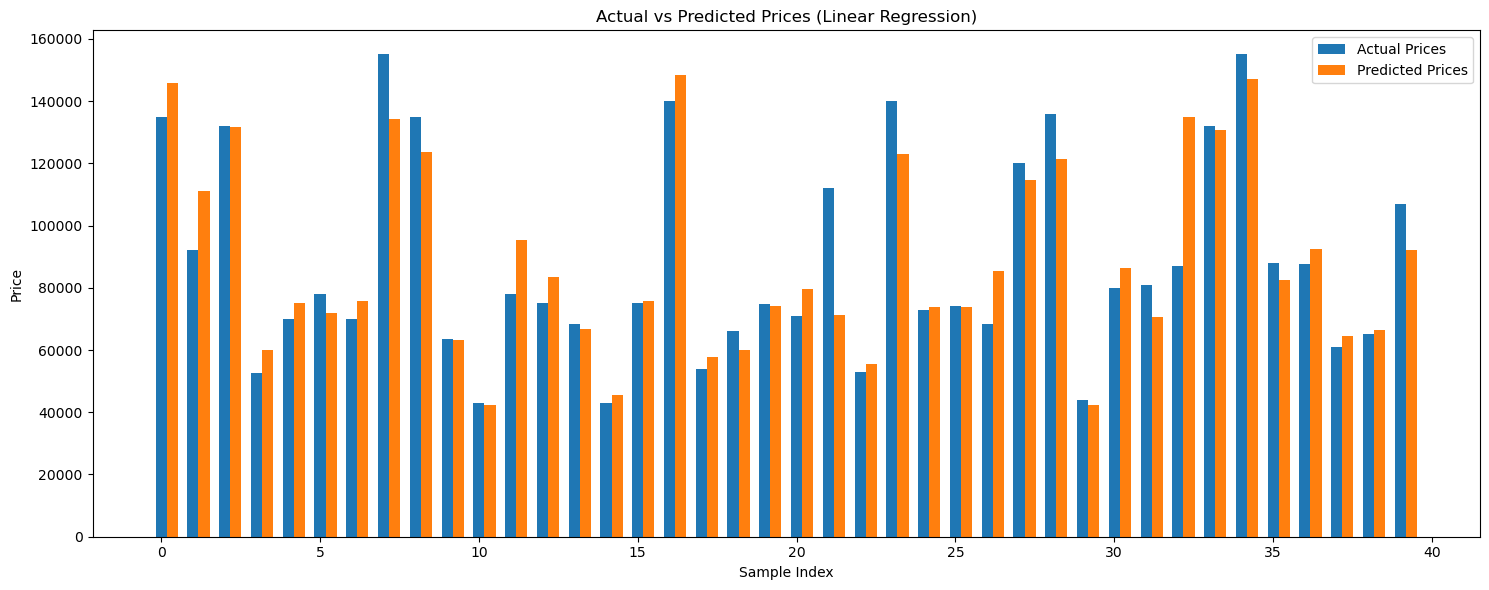

-------------------------------------------------------------------
Random Forest - R²: 0.88
Random Forest - MAE: 6446
Random Forest - RMSE: 9539


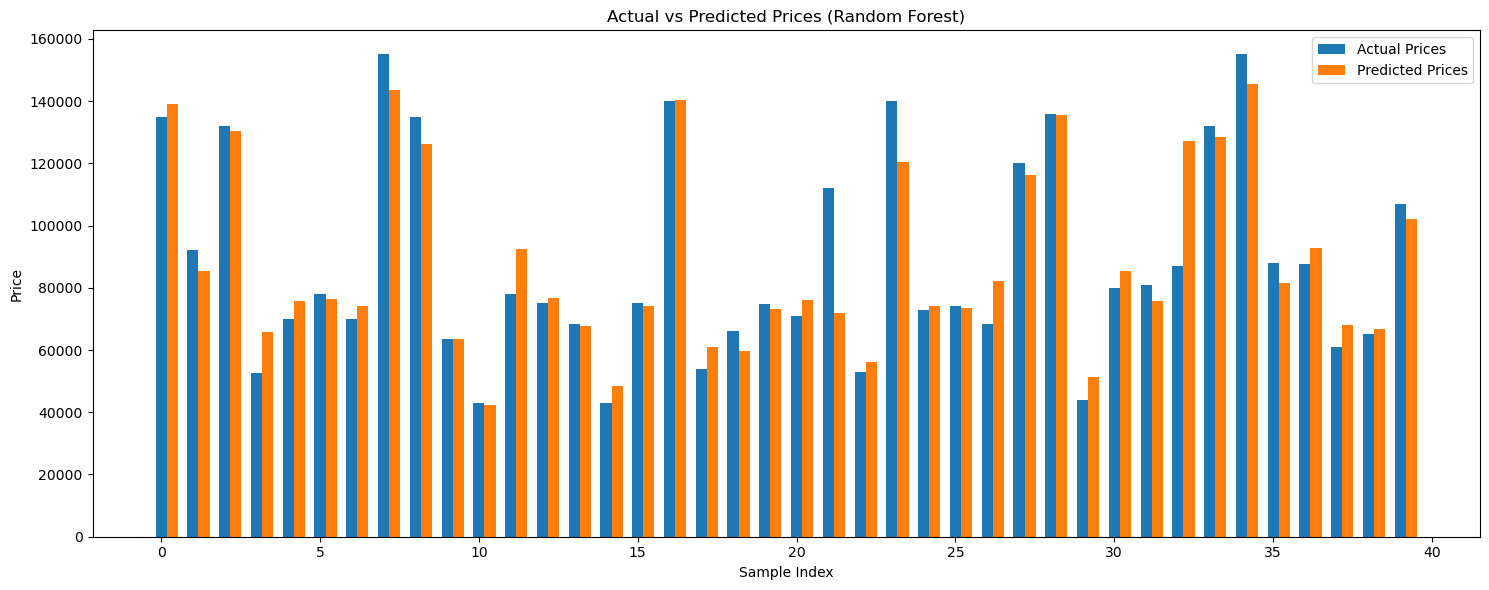

-------------------------------------------------------------------
XGBoost - Test R²: 0.898
XGBoost - MAE: 5954
XGBoost - RMSE: 8820


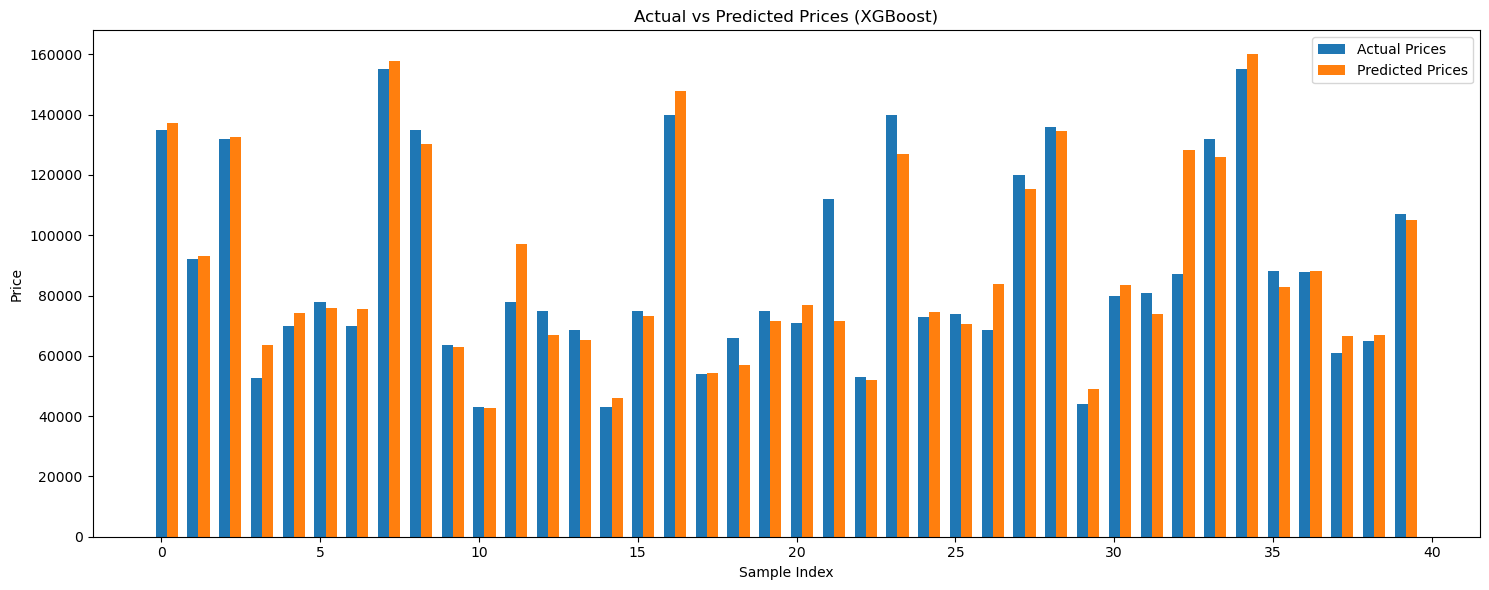

BINAGADI

Dataset: BINAGADI

Linear Regression - R²: 0.88
Linear Regression - MAE: 18682
Linear Regression - RMSE: 24068


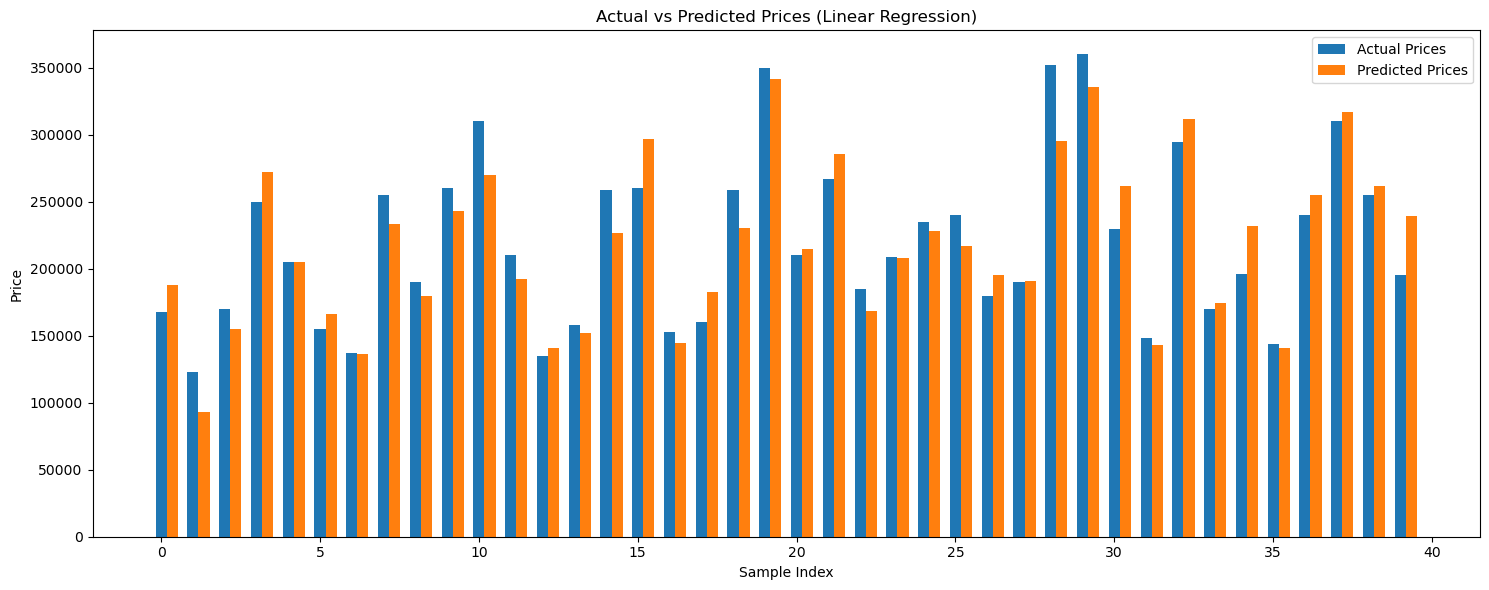

-------------------------------------------------------------------
Random Forest - R²: 0.911
Random Forest - MAE: 15171
Random Forest - RMSE: 21063


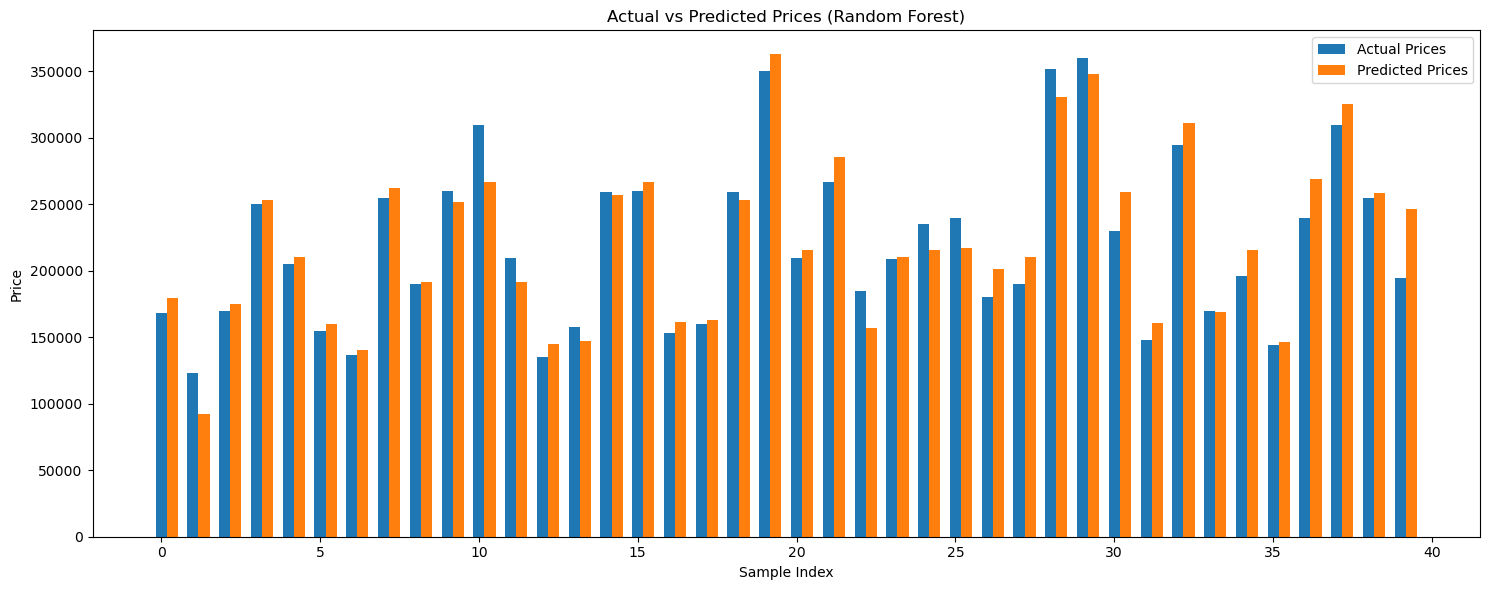

-------------------------------------------------------------------
XGBoost - Test R²: 0.924
XGBoost - MAE: 13979
XGBoost - RMSE: 19424


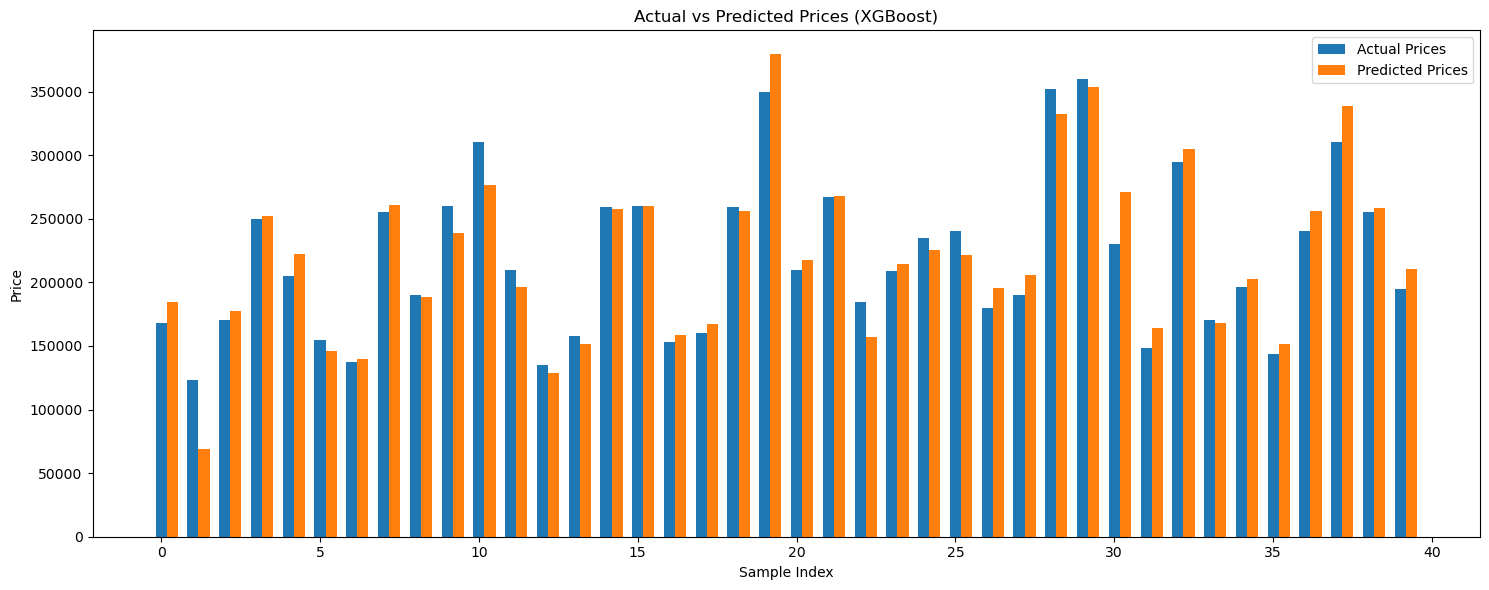

KHATAI

Dataset: KHATAI

Linear Regression - R²: 0.877
Linear Regression - MAE: 42743
Linear Regression - RMSE: 71890


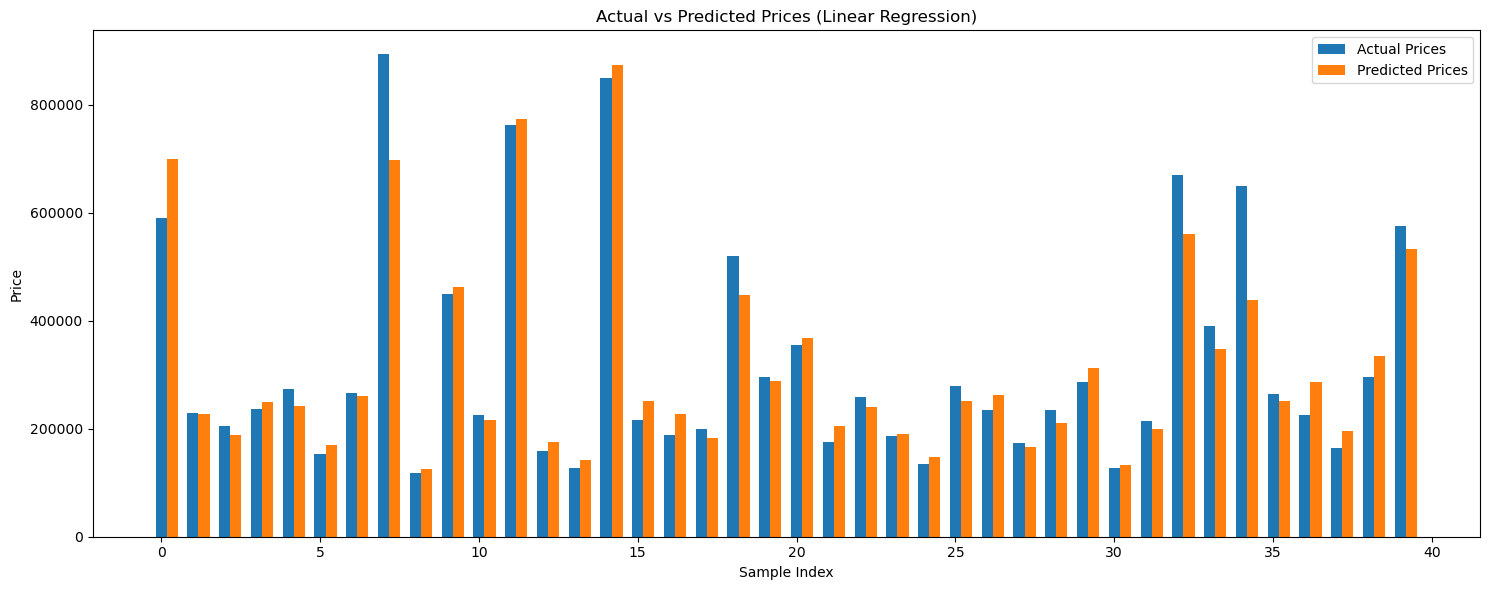

-------------------------------------------------------------------
Random Forest - R²: 0.94
Random Forest - MAE: 24891
Random Forest - RMSE: 44820


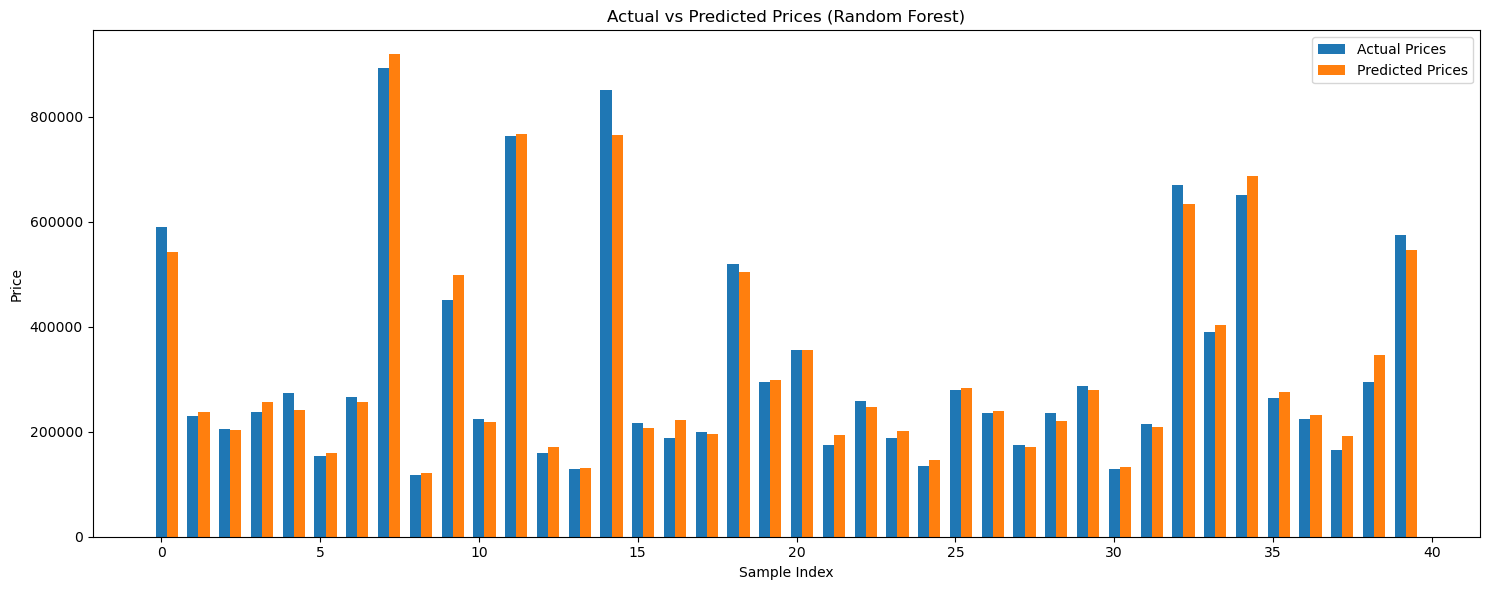

-------------------------------------------------------------------
XGBoost - Test R²: 0.948
XGBoost - MAE: 22952
XGBoost - RMSE: 41505


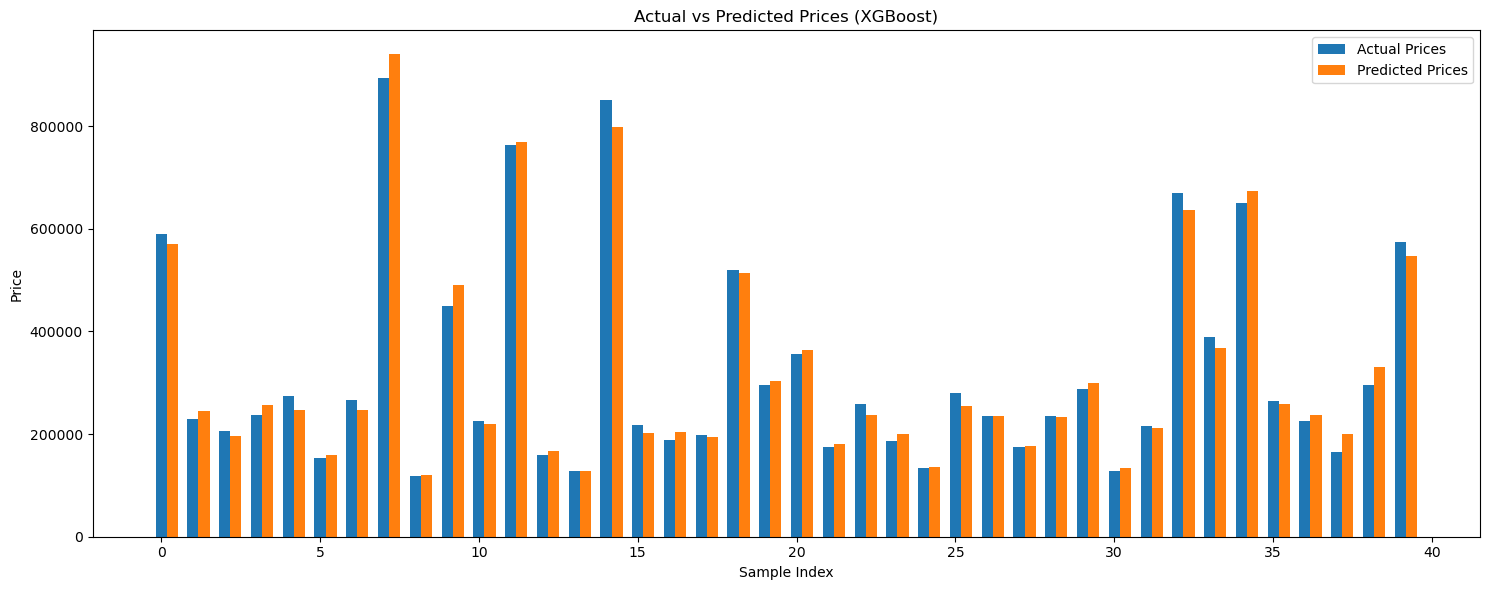

NARIMANOV

Dataset: NARIMANOV

Linear Regression - R²: 0.812
Linear Regression - MAE: 45544
Linear Regression - RMSE: 77991


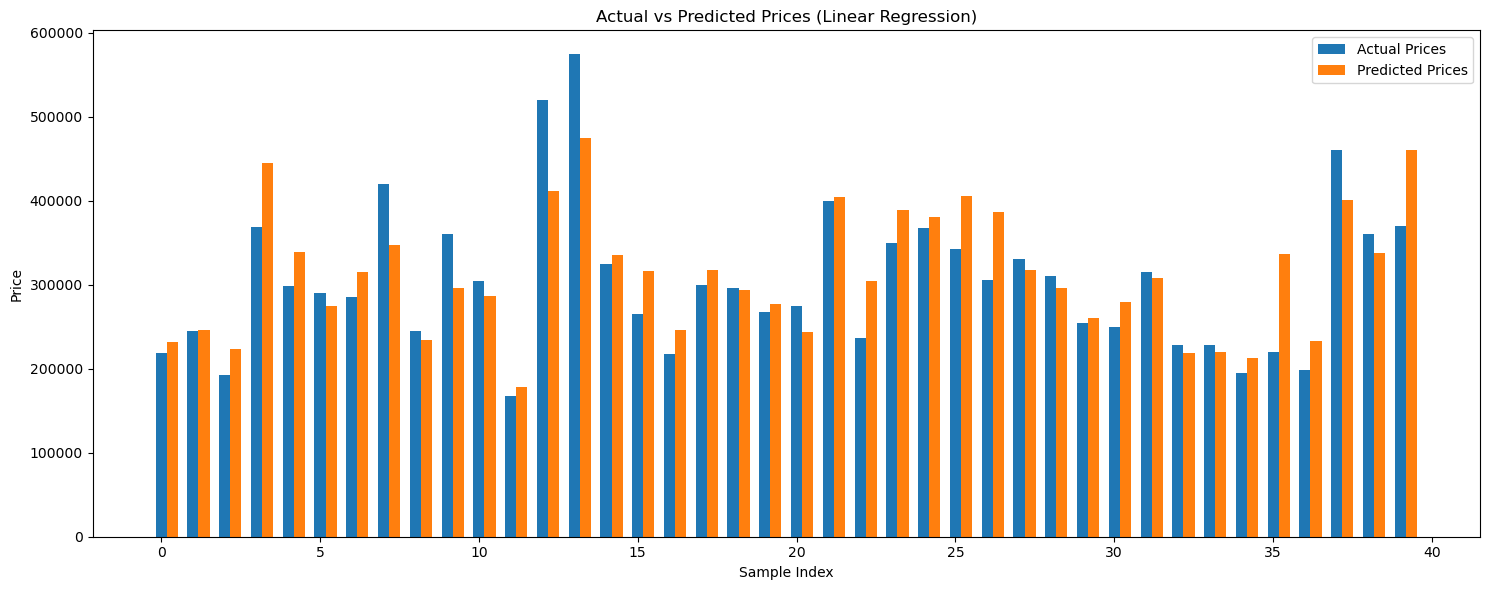

-------------------------------------------------------------------
Random Forest - R²: 0.857
Random Forest - MAE: 32460
Random Forest - RMSE: 58295


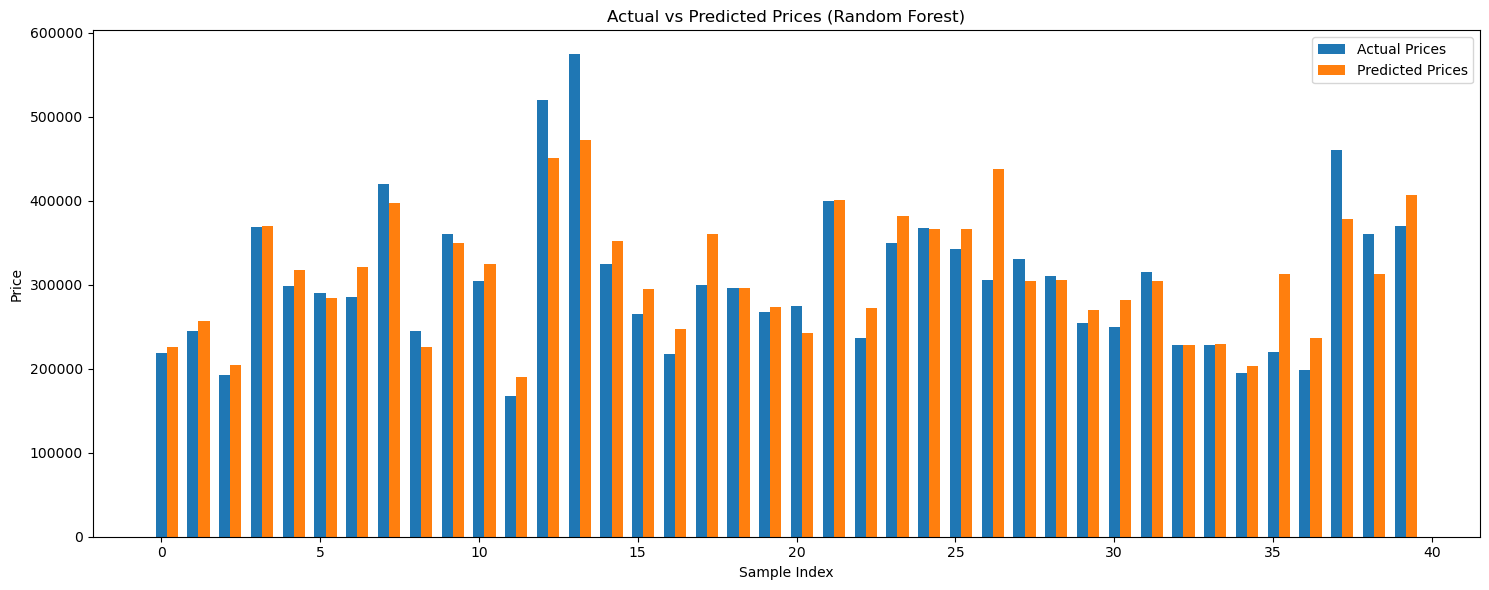

-------------------------------------------------------------------
XGBoost - Test R²: 0.876
XGBoost - MAE: 29569
XGBoost - RMSE: 54372


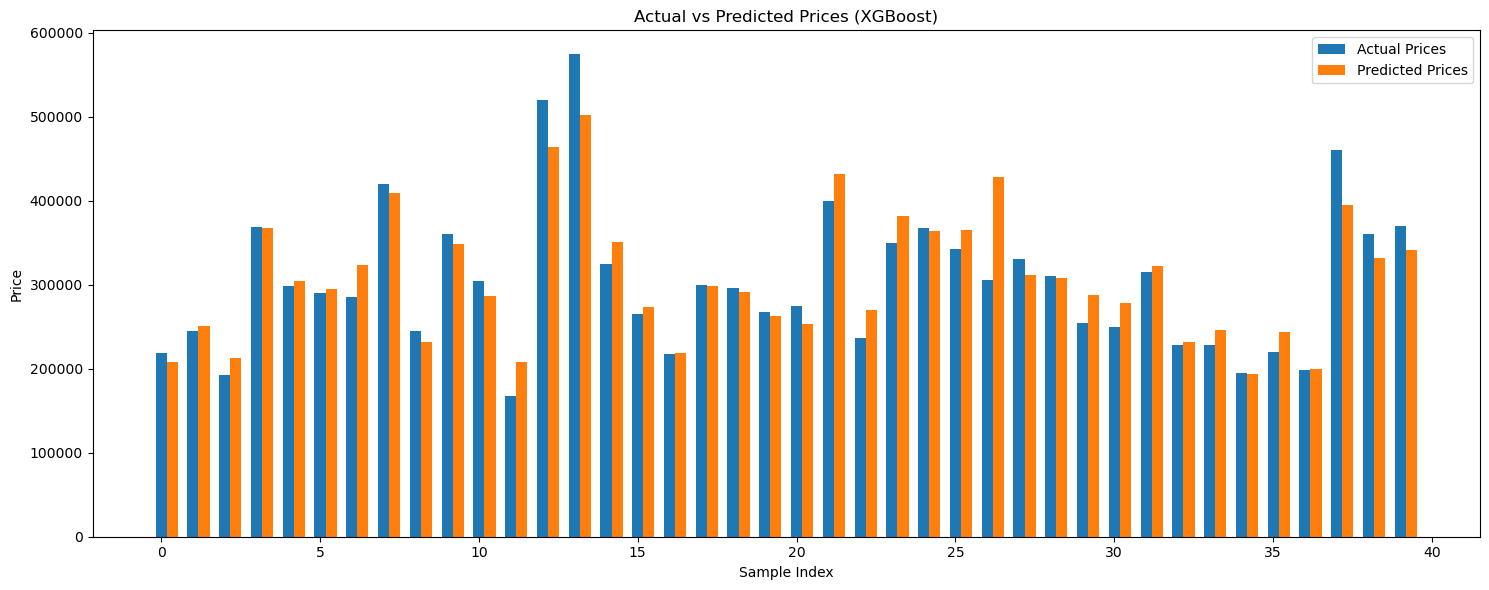

NASIMI

Dataset: NASIMI

Linear Regression - R²: 0.852
Linear Regression - MAE: 45873
Linear Regression - RMSE: 75673


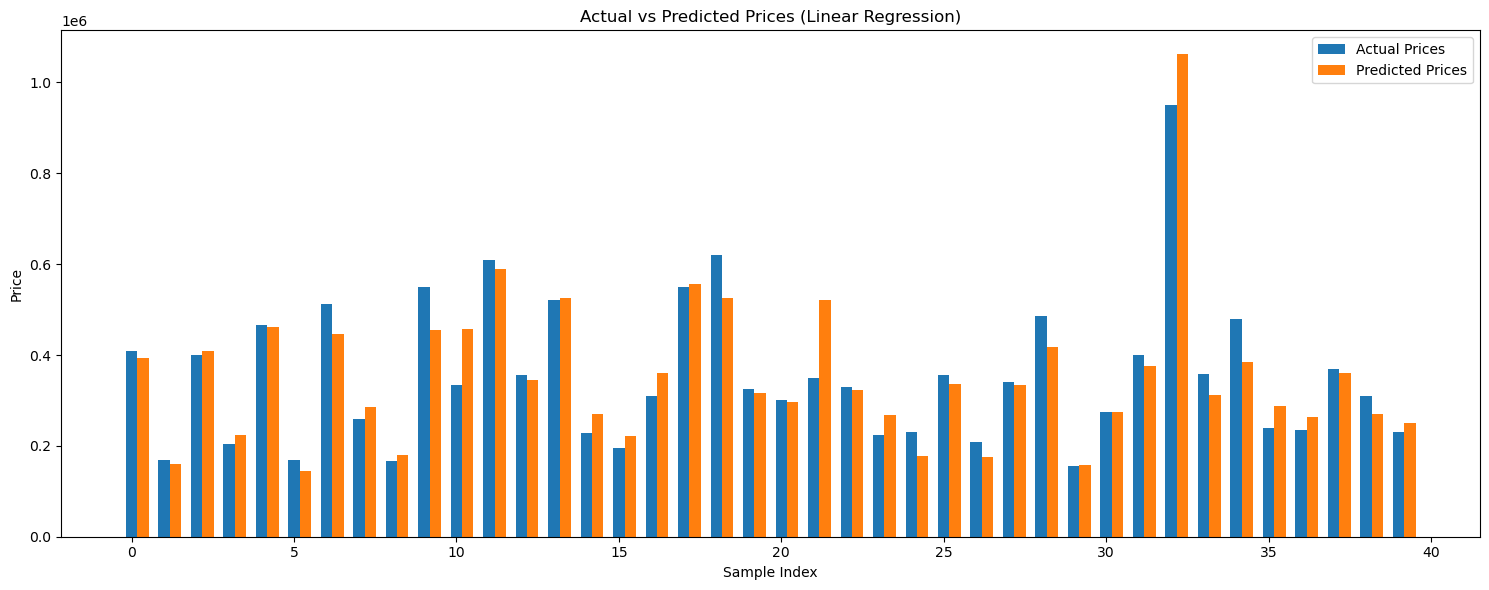

-------------------------------------------------------------------
Random Forest - R²: 0.856
Random Forest - MAE: 36698
Random Forest - RMSE: 65198


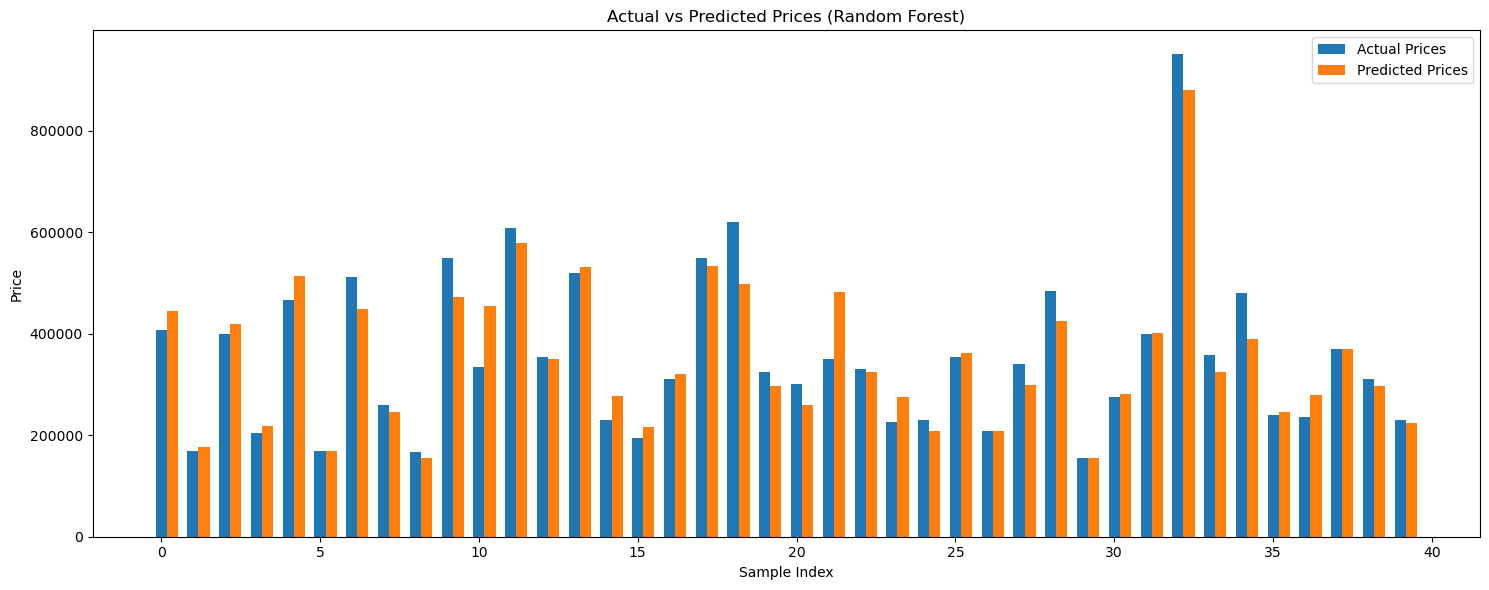

-------------------------------------------------------------------
XGBoost - Test R²: 0.876
XGBoost - MAE: 33017
XGBoost - RMSE: 60313


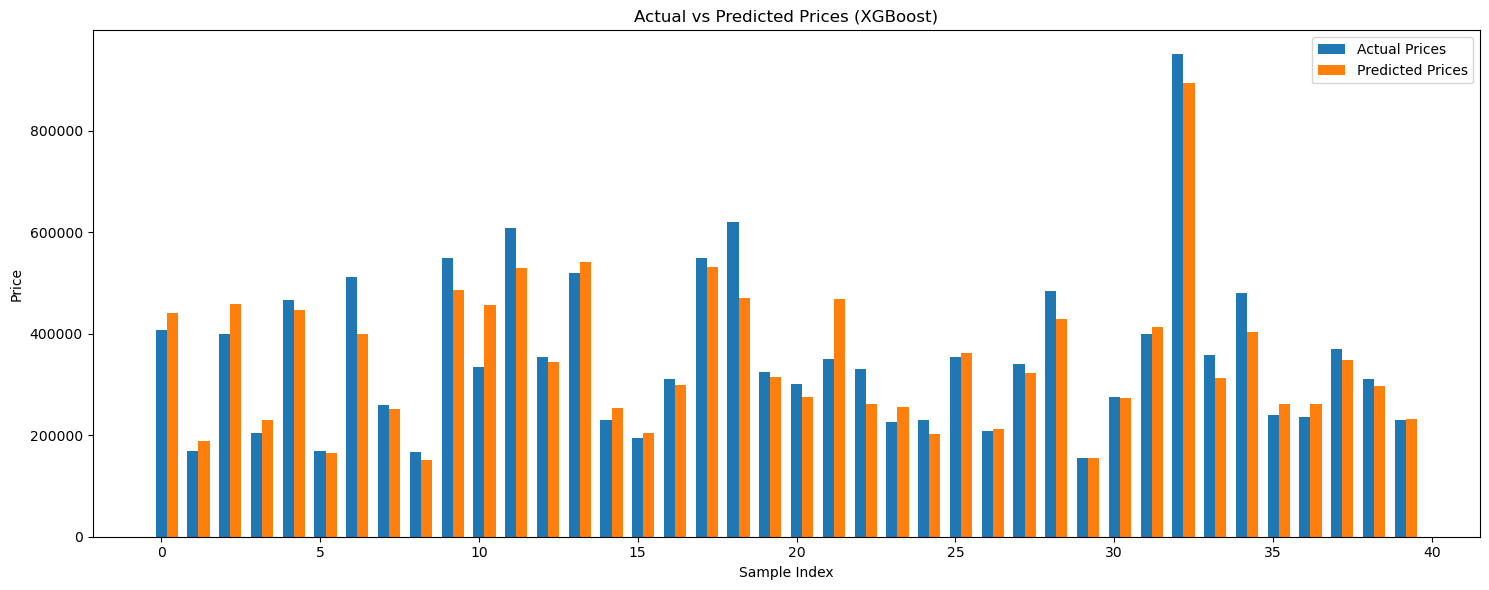

NIZAMI

Dataset: NIZAMI

Linear Regression - R²: 0.839
Linear Regression - MAE: 23125
Linear Regression - RMSE: 31010


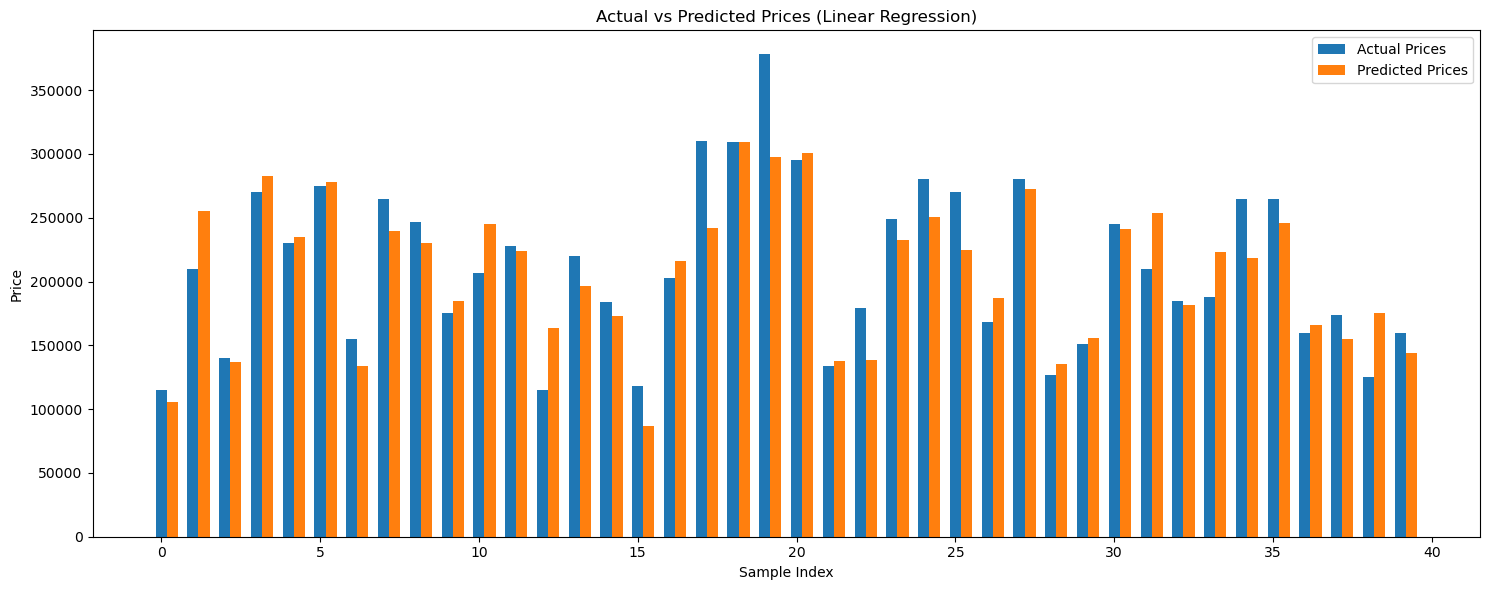

-------------------------------------------------------------------
Random Forest - R²: 0.853
Random Forest - MAE: 18383
Random Forest - RMSE: 27899


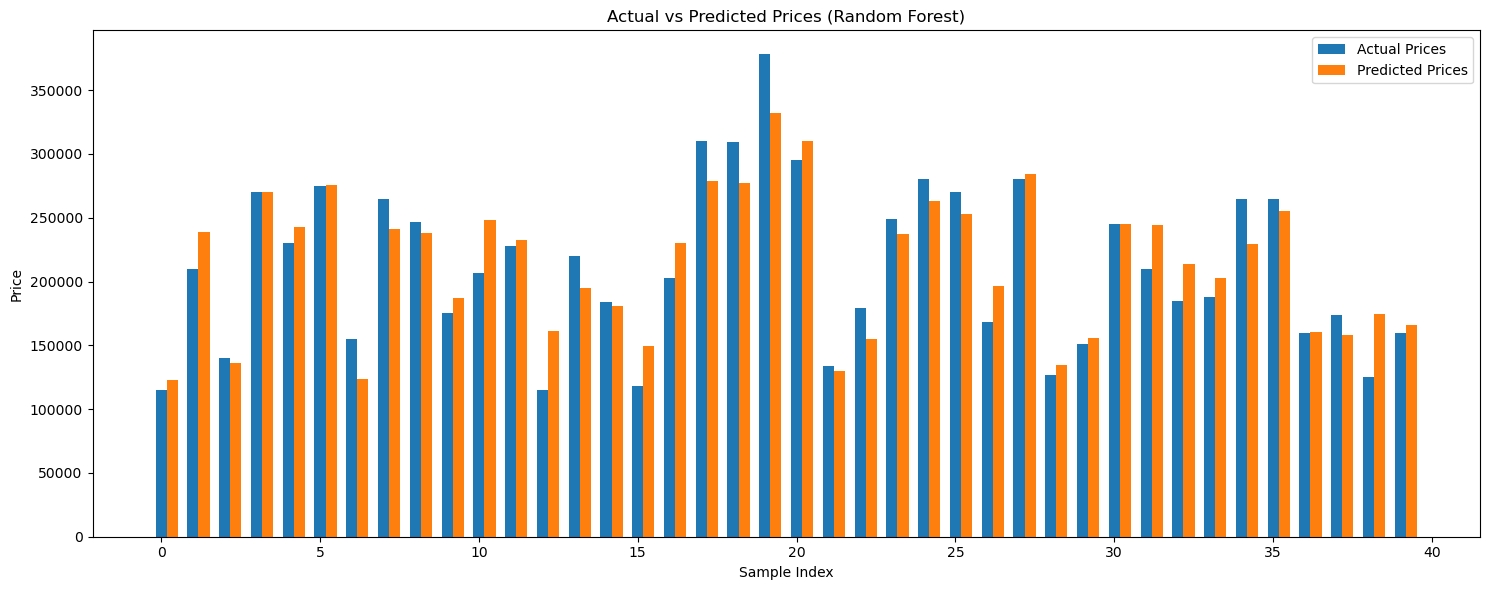

-------------------------------------------------------------------
XGBoost - Test R²: 0.863
XGBoost - MAE: 17539
XGBoost - RMSE: 26944


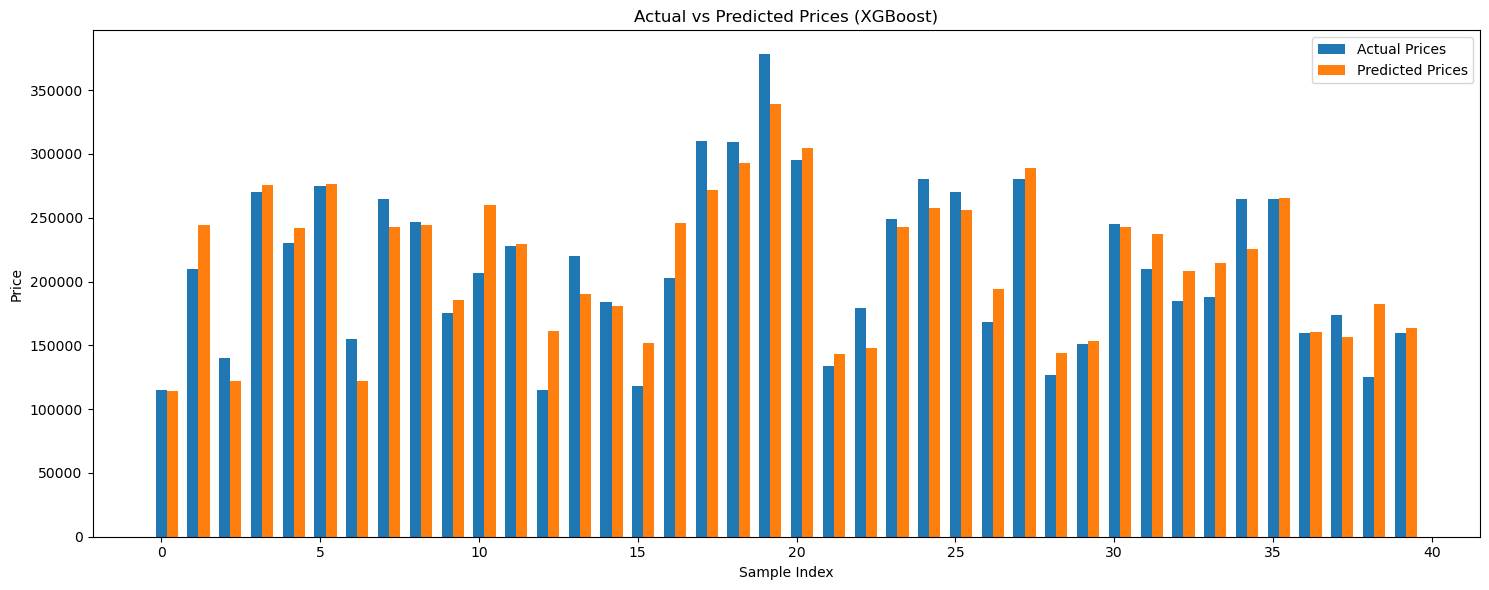

SEBAIL

Dataset: SEBAIL

Linear Regression - R²: 0.837
Linear Regression - MAE: 44685
Linear Regression - RMSE: 66740


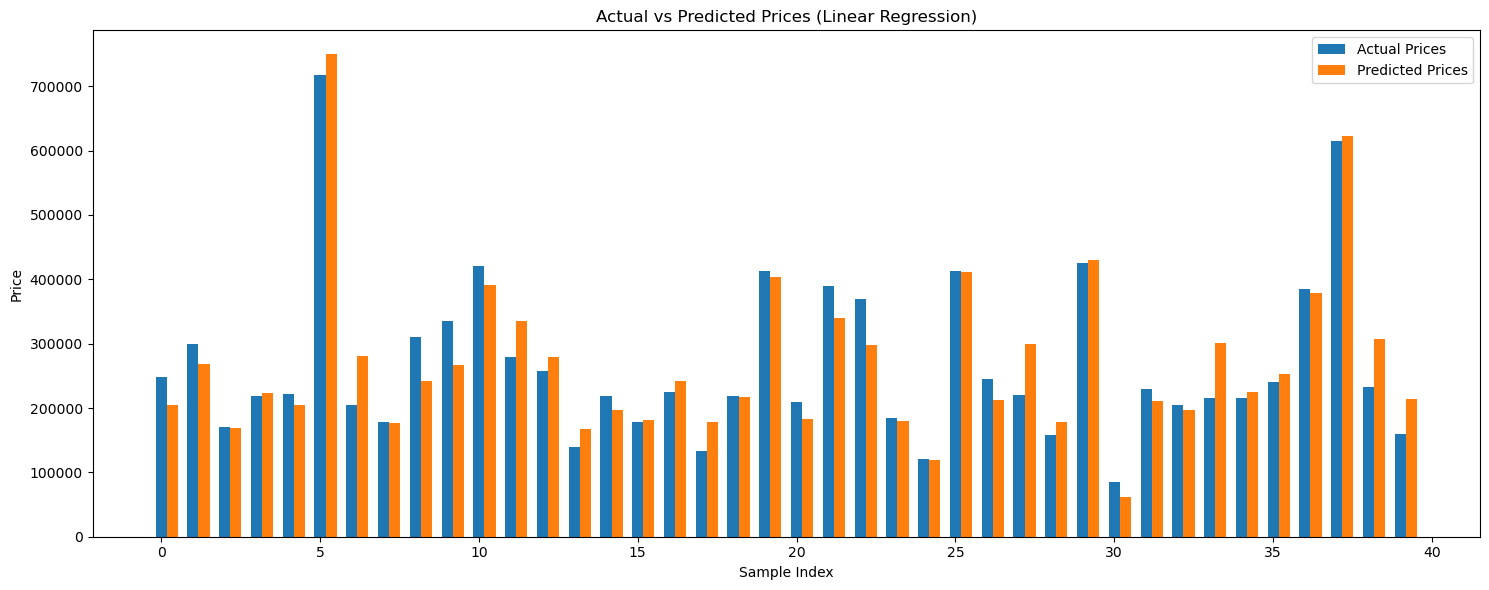

-------------------------------------------------------------------
Random Forest - R²: 0.884
Random Forest - MAE: 37537
Random Forest - RMSE: 53064


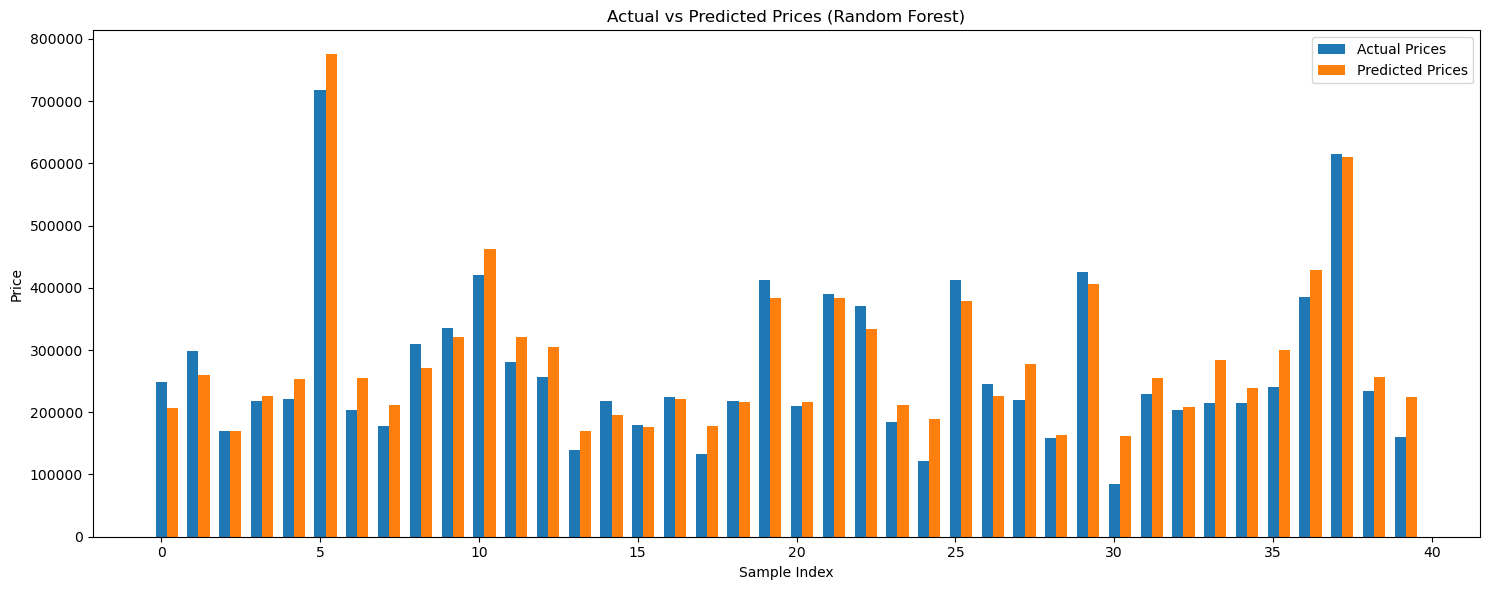

-------------------------------------------------------------------
XGBoost - Test R²: 0.889
XGBoost - MAE: 34802
XGBoost - RMSE: 51764


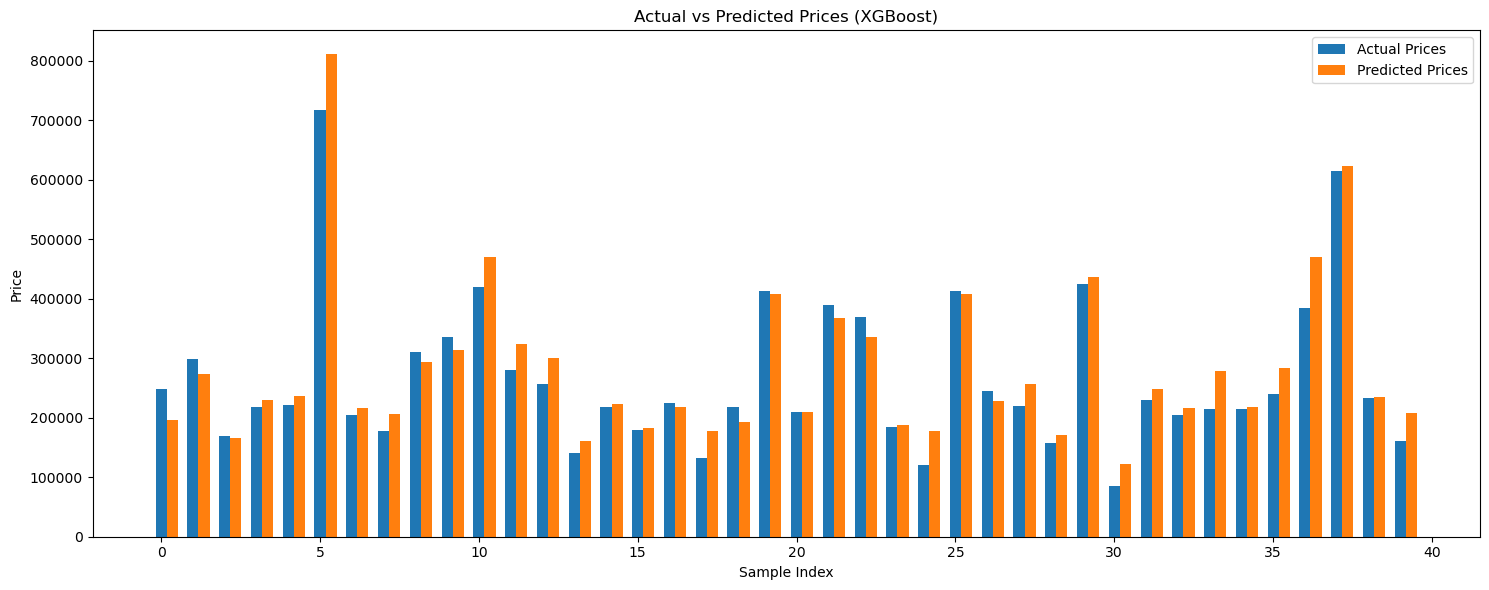

YASAMAL

Dataset: YASAMAL

Linear Regression - R²: 0.847
Linear Regression - MAE: 41615
Linear Regression - RMSE: 66141


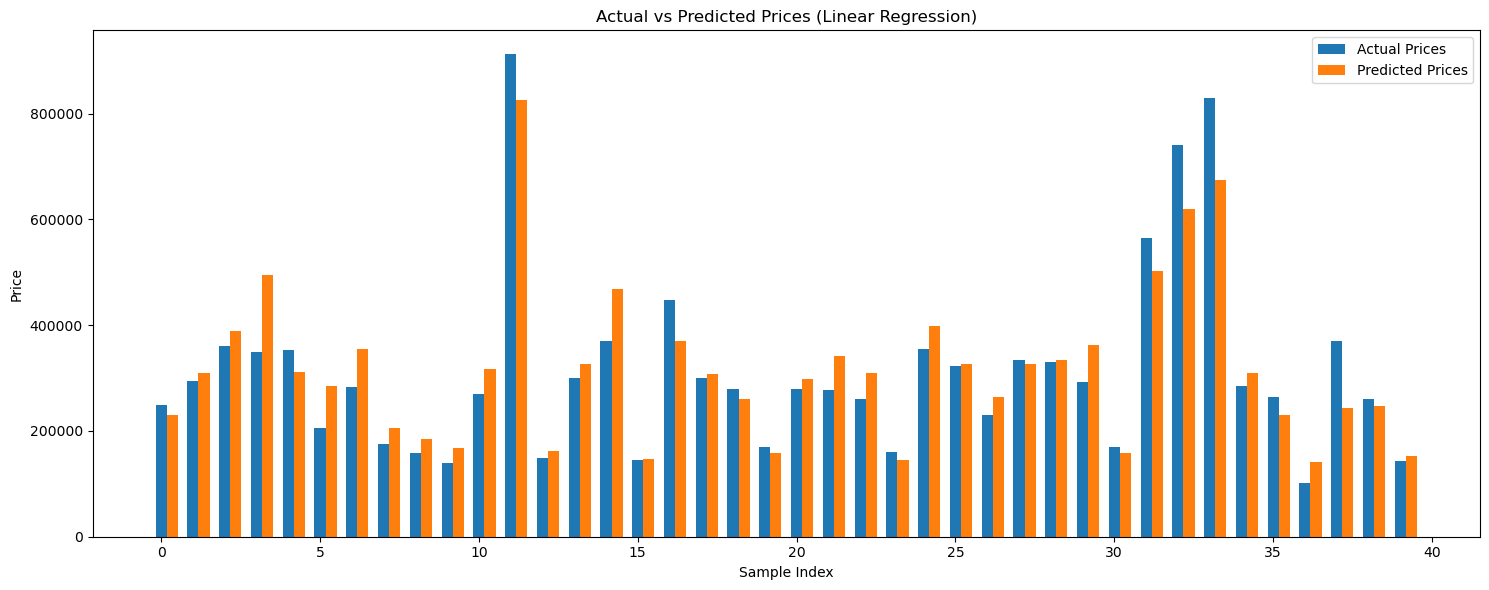

-------------------------------------------------------------------
Random Forest - R²: 0.898
Random Forest - MAE: 26808
Random Forest - RMSE: 48244


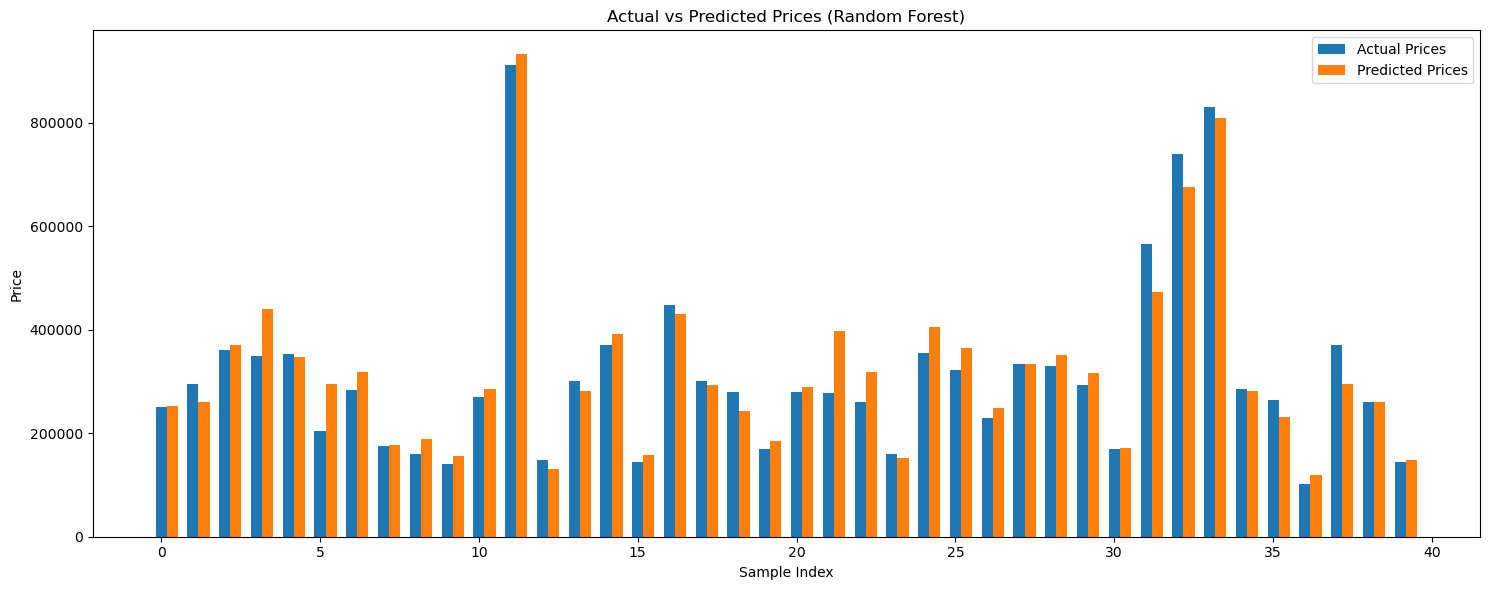

-------------------------------------------------------------------
XGBoost - Test R²: 0.909
XGBoost - MAE: 24911
XGBoost - RMSE: 45695


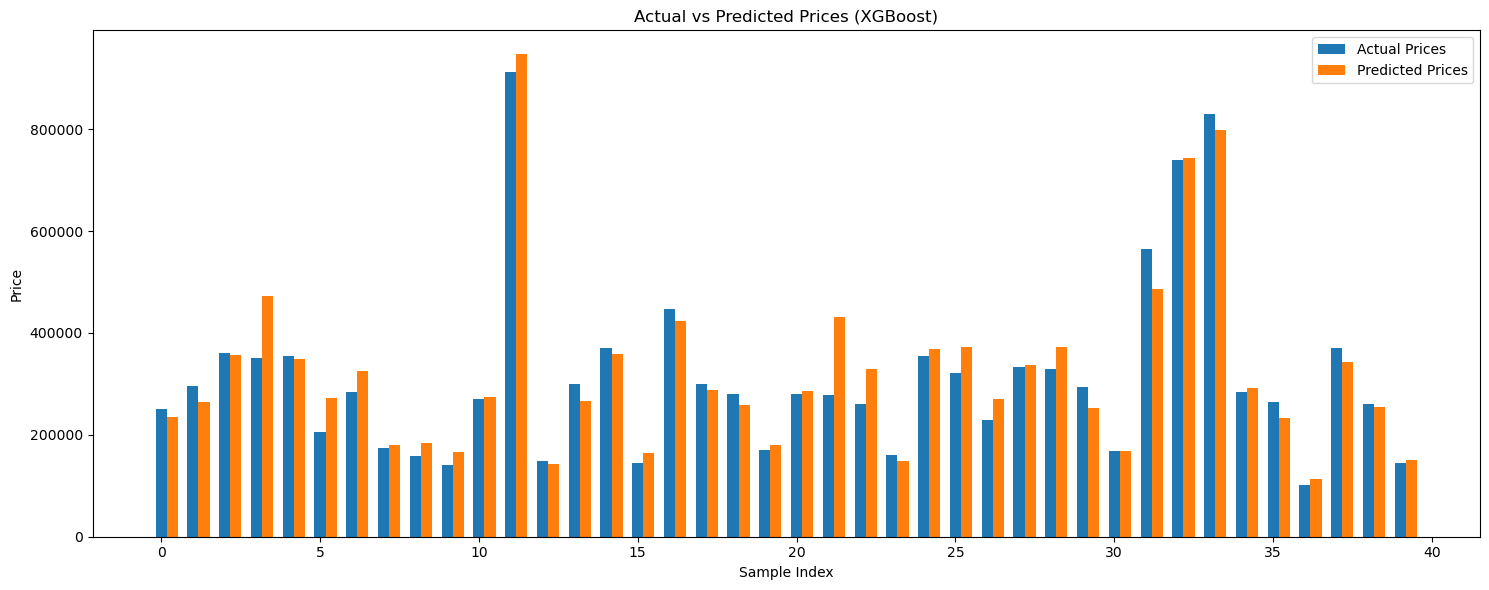

In [944]:
save_path = r"C:\Users\TEXNO\Desktop\Jupiter\Bina_az_saved_models"
os.makedirs(save_path, exist_ok=True)

for name, df in dfs.items():
    name = name.replace('_DF', '')
    print(name)
    median = df['prices'].median()
    q1 = df['prices'].quantile(0.25)
    q3 = df['prices'].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = max(df['prices'].min(), q1 - 1.5 * iqr)
    upper_whisker = min(df['prices'].max(), q3 + 1.5 * iqr)
    
    if name == 'YASAMAL':
        df = df[df['prices'] <= upper_whisker * 2]

    elif name == 'NARIMANOV' or name == 'SEBAIL':
        df = df[df['prices'] <= upper_whisker * 3]

    elif name == 'BINAGADI':
        df = df[df['prices'] <= upper_whisker]
        
    else:
        df = df[df['prices'] <= upper_whisker * 1.5]

    joblib.dump(df, os.path.join(save_path, f"{name}_data.pkl"))
    
    print(f'\nDataset: {name}\n')
    
    # Modelling
    
    # Linear regression
    X = df.drop(['prices', 'url', 'images', 'location'], axis=1)
    y = np.log1p(df['prices'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    standard_scl = StandardScaler()
    X_train = standard_scl.fit_transform(X_train)
    X_test = standard_scl.transform(X_test)
    
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    linear_model = LinearRegression()
    linear_model.fit(X_train_poly, y_train)
    
    y_pred_log = linear_model.predict(X_test_poly)
    train_pred_log = linear_model.predict(X_train_poly)
    
    r2_test_log = r2_score(y_test, y_pred_log)
    r2_train_log = r2_score(y_train, train_pred_log)
    
    y_pred_real = np.expm1(y_pred_log)
    y_test_real = np.expm1(y_test)
    train_pred_real = np.expm1(train_pred_log)
    y_train_real = np.expm1(y_train)
    
    mae = round(mean_absolute_error(y_test_real, y_pred_real))
    rmse = round(np.sqrt(mean_squared_error(y_test_real, y_pred_real)))

    print(f"Linear Regression - R²: {round(r2_test_log, 3)}")
    print(f"Linear Regression - MAE: {round(mae, 3)}")
    print(f"Linear Regression - RMSE: {round(rmse, 3)}")

    joblib.dump(linear_model, os.path.join(save_path, f"{name}_linear.pkl"))
    joblib.dump(standard_scl, os.path.join(save_path, f"{name}_scaler.pkl"))
    joblib.dump(poly, os.path.join(save_path, f"{name}_poly.pkl"))

    n = 40
    indices = np.arange(n)
    plt.figure(figsize=(15,6))
    bar_width = 0.35
    plt.bar(indices, y_test_real[:n], width=bar_width, label="Actual Prices")
    plt.bar(indices + bar_width, y_pred_real[:n], width=bar_width, label="Predicted Prices")
    plt.xlabel("Sample Index")
    plt.ylabel("Price")
    plt.title("Actual vs Predicted Prices (Linear Regression)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Random Forest
    X = df.drop(['prices', 'url', 'images', 'location'], axis=1)
    y = df['prices']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    random_forest_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=12,      
        min_samples_leaf=3,
        min_samples_split=5,
        max_features=0.6,  
        random_state=42)
    random_forest_model.fit(X_train, y_train)
    y_pred = random_forest_model.predict(X_test)
    y_diff = np.abs(y_test - y_pred)
    train_pred = random_forest_model.predict(X_train)
    print('-------------------------------------------------------------------')
    print(f"Random Forest - R²: {round(r2_score(y_test, y_pred), 3)}")
    print(f"Random Forest - MAE: {round(mean_absolute_error(y_test, y_pred))}")
    print(f"Random Forest - RMSE: {round(np.sqrt(mean_squared_error(y_test, y_pred)))}")

    joblib.dump(random_forest_model, os.path.join(save_path, f"{name}_rf.pkl"))

    n = 40
    indices = np.arange(n)
    plt.figure(figsize=(15,6))
    bar_width = 0.35
    plt.bar(indices, y_test[:n], width=bar_width, label="Actual Prices")
    plt.bar(indices + bar_width, y_pred[:n], width=bar_width, label="Predicted Prices")
    plt.xlabel("Sample Index")
    plt.ylabel("Price")
    plt.title("Actual vs Predicted Prices (Random Forest)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Xgboost 
    X = df.drop(['prices', 'url', 'images', 'location'], axis=1)
    y = df['prices']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    xgb_model = XGBRegressor(n_estimators=1000,
                             learning_rate=0.05,
                             max_depth=6,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             random_state=42,
                             n_jobs=-1
                            )
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    y_diff = np.abs(y_test - y_pred)
    r2 = round(r2_score(y_test, y_pred), 3)

    mae = round(mean_absolute_error(y_test, y_pred))
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred))) 

    train_pred = xgb_model.predict(X_train)
    print('-------------------------------------------------------------------')
    print(f"XGBoost - Test R²: {r2}")
    print(f"XGBoost - MAE: {mae}")
    print(f"XGBoost - RMSE: {rmse}")

    joblib.dump(xgb_model, os.path.join(save_path, f"{name}_xgb.pkl"))

    n = 40
    indices = np.arange(n)
    plt.figure(figsize=(15,6))
    bar_width = 0.35
    plt.bar(indices, y_test[:n], width=bar_width, label="Actual Prices")
    plt.bar(indices + bar_width, y_pred[:n], width=bar_width, label="Predicted Prices")
    plt.xlabel("Sample Index")
    plt.ylabel("Price")
    plt.title("Actual vs Predicted Prices (XGBoost)")
    plt.legend()
    plt.tight_layout()
    plt.show()